In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score

In [2]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
# UTILS
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [3]:
# Extract the n values stored in str_in and expressed as "col_1=val_1,col_2=val_2,...,col_n=val_n" into n columns
def split(str_in):
    pairs = str_in.split(',')
    res = {}
    for pair in pairs:
        col_name, value = pair.split('=')
        res[col_name] = value
    return res

# Used to check if all the strings in a column of a dataframe are digits
def df_isdigit(s):
    return s.isdigit()

# Used to standardize the unit of measurement, so as to express everything in gigabytes. 
def convert_to_GB(input_string): 
    num = input_string[:-1]
    res = float(num)
    unit = input_string[-1]

    if unit == 'M':
        return res / 1024
    elif unit == 'G':
        return res
    elif unit == 'T':
        return res * 1024
    else:
        raise ValueError("Unit of measurement not recognized")

# Used to reset the df between experiments
def reset_df(df_in):
    if (df_in['cpu'] == df_in['billing']).all():
        df_out = df_in.drop(columns='billing')

    if df_out['cpu'].apply(df_isdigit).all():
        df_out['cpu'] = df_out['cpu'].astype(int)
    
    if df_out['node'].apply(df_isdigit).all():
        df_out['node'] = df_out['node'].astype(int)
    
    if df_out['gres/gpu'].apply(df_isdigit).all():
        df_out['gres/gpu'] = df_out['gres/gpu'].astype(int)
    
    df_out['mem'] = df_out['mem'].apply(convert_to_GB)
    df_out.rename(columns={'mem': 'mem (GB)'}, inplace=True)
    
    df_out['time_limit'] = df_out['time_limit'].astype(float)
    df_out['run_time'] = df_out['run_time'].astype(float) / 60
    
    df_out['user_id'] = pd.factorize(df_out['user_id'])[0]
    df_out['qos'] = pd.factorize(df_out['qos'])[0]

    return df_out

def plot_regression(y_test, y_pred, color, title):
    plt.figure(figsize=(12, 6))
    plt.scatter(y_test, y_pred, edgecolor='k', facecolor=color, alpha=0.5, label='Predicted vs Actual')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.show()

def plot_residuals(y_test, y_pred):
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.xlabel('Predicted Runtime')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted Runtime')
    plt.show()

# Evaluate if the models overestimate, underestimate or exactly (down to 0.5 second) predict the runtime
# Show the minimum, maximum and average error in each case
# Evaluate if the error is less than one our
def evaluate_models(previsions, true_values):
    for p in previsions:  
        counter_over = 0; counter_under = 0; counter_exact = 0
        min_over = np.inf; min_under = np.inf; max_over = 0; max_under = 0
        total_over = 0; total_under = 0
        sensivity = 1/120
        errors = np.array(p[1]) - true_values
        for e in errors:
            if e > sensivity:
                counter_over += 1
                if e < min_over:
                    min_over = e
                if e > max_over:
                    max_over = e
                total_over += e
            elif e < -sensivity:
                counter_under += 1
                if abs(e) < min_under:
                    min_under = abs(e)
                if abs(e) > max_under:
                    max_under = abs(e)
                total_under += abs(e)
            else:
                counter_exact += 1

        hist_over, bin_edges_over = np.histogram(errors, bins=np.arange(0, 1440 + 60, 60))
        hist_under, bin_edges_under = np.histogram(errors, bins=np.arange(-1440, 0 + 60, 60))
        
        print('The model "{}":'.format(p[0]))
        print('   - Overestimates the runtime in {:.2f}% of the cases ({} out of {})'.format(counter_over/errors.size*100, counter_over, errors.size))
        print('       • min(error)={:.2f} ; max(error)={:.2f} ; avg(error)={:.2f}'.format(min_over, max_over, total_over/counter_over))
        print('       • The error is less than one hour in {:.2f}% of the cases ({} out of {})'.format(hist_over[0]/counter_over*100, hist_over[0], counter_over))
#       print(tabulate([bin_edges_over/60, hist_over], tablefmt="heavy_grid"))
        print('   - Underestimates the runtime in {:.2f}% of the cases ({} out of {})'.format(counter_under/errors.size*100, counter_under, errors.size))
        print('       • min(error)={:.2f} ; max(error)={:.2f} ; avg(error)={:.2f}'.format(min_under, max_under, total_under/counter_under))
        print('       • The error is less than one hour in {:.2f}% of the cases ({} out of {})'.format(hist_under[23]/counter_under*100, hist_under[23], counter_under))
#       print(tabulate([bin_edges_under/60, hist_under], tablefmt="heavy_grid"))
        print('   - Exactly predict the runtime in the {:.2f}% of the cases ({} out of {})\n'.format(counter_exact/errors.size*100, counter_exact, errors.size))

# Shows how much, as a percentage, the predicted runtime is better than the initial guesses ("time_limit") at approximating the actual run_time
# Also, shows how much, for valid predictions, as a percentage, the predicted runtime is better than the initial guesses ("time_limit") at approximating the actual run_time
def compare_previsions(previsions, initial_guesses, true_values):
    for p in previsions:
        p_error = p[1] - true_values
        abs_p_error = np.abs(p[1] - true_values)
        abs_ig_error = np.abs(initial_guesses - true_values) + 0.00001
        
        # The predicted runtime is better than "time_limit" if is in the range [0, time_limit]
        better = (abs_p_error < abs_ig_error) & (p_error > 0)

        total_improvements = np.where(better, 100 * (abs_ig_error - abs_p_error) / abs_ig_error, 0)
        avg_total_improvement = total_improvements.mean()

        good_improvements = np.where(better, 100 * (abs_ig_error - abs_p_error) / abs_ig_error, np.nan)
        good_improvements = good_improvements[~np.isnan(good_improvements)]
        avg_good_improvement = good_improvements.mean()
        
        print('The model "{}":'.format(p[0]))
        print('   - In general, is more effective at approximating the actual "run_time" with respect to "time_limit" by {:.2f}%'.format(avg_total_improvement))
        print('   - In particular, for valid predictions (when it does not underestimate the actual "run_time"), it is more effective by {:.2f}%\n'.format(avg_good_improvement))

# Calculates and shows the confidence intervals for the models
def get_confidence_intervals(previsions, confidence_level='95%'):
    confidences = []
    
    # Set the value of z
    if confidence_level == '90%':
        z = 1.645
    elif confidence_level == '95%':
        z = 1.96
    elif confidence_level == '99%':
        z = 2.58

    for p in previsions:
        # Calculate the mean and standard deviation
        mean_p = np.mean(p[1])
        std_p = np.std(p[1])
        # Define the confidence interval
        ci_p = z * std_p
        # Calculate the upper and lower bounds of the confidence interval 
        lb_p = mean_p - ci_p
        # If the lower bound is negative, set it to 0  
        if lb_p < 0: 
            lb_p = 0
        ub_p = mean_p + ci_p

        confidences.append((p[0], '[{:.2f}, {:.2f}]'.format(lb_p, ub_p)))

    title = 'CONFIDENCE INTERVAL' + ' (' + confidence_level + ')'
    print(tabulate(confidences, headers=['MODEL', title], tablefmt="heavy_grid", stralign="center"))

In [4]:
df0 = pd.read_parquet("job_table.parquet")
print(df0.shape)

(6236346, 100)

In [5]:
# The submission time features are collected only in jobs performed between May and November 2020, so we focus on that split of data for the experiments.
# Theese features are stored as strings in the "tres_req_str" field, so we filter all the data for which that field is a non-empty string.

# Check that the data in the "tres_req_str" field are strings
if all(isinstance(x, str) for x in df0['tres_req_str']):
    # Filter all the data for which that field is a non-empty string
    df0 = df0[df0['tres_req_str'] != '']

print(df0.shape)

In [7]:
df0.head()

pn_min_cpus                resize_time ntasks_per_socket tres_freq comment  \
0           4  1970-01-01 01:00:00+00:00                                       
1           4  1970-01-01 01:00:00+00:00                                       
2          32  1970-01-01 01:00:00+00:00                                       
3           4  1970-01-01 01:00:00+00:00                                       
4         256  1970-01-01 01:00:00+00:00               2.0                     

  ntasks_per_socket_str     std_in array_task_throttle max_nodes contiguous  \
0             UNLIMITED  /dev/null                             0      False   
1             UNLIMITED  /dev/null                             0      False   
2             UNLIMITED  /dev/null                             0      False   
3             UNLIMITED  /dev/null                             0      False   
4                     2  /dev/null                             1      False   

   ...                                     cpus_allocated billable_tres  \
0  ...                                     {'r245n04': 4}           4.0   
1  ...                                     {'r250n19': 4}           4.0   
2  ...  {'r212n10': 32, 'r212n15': 32, 'r212n14': 32, ...         256.0   
3  ...                                     {'r209n15': 4}           4.0   
4  ...                                                                    

            last_sched_eval              eligible_time power_flags  \
0  2020-05-22T01:07:00.000Z  2020-05-22 01:06:05+00:00           0   
1  2020-05-22T01:07:00.000Z  2020-05-22 01:06:10+00:00           0   
2  2020-05-22T09:28:37.000Z  2020-05-22 09:28:37+00:00           0   
3  2020-05-22T20:39:06.000Z  2020-05-22 01:05:39+00:00           0   
4  2020-05-22T18:56:39.000Z  2020-05-22 18:56:39+00:00           0   

  cores_per_socket sockets_per_node shared cpus_per_task    req_nodes  
0                                       OK             4  ['r245n04']  
1                                       OK             4  ['r250n19']  
2                                       OK             1               
3                                       OK             4  ['r209n15']  
4                                       OK            32               

[5 rows x 100 columns]

In [8]:
# sorted(df0.columns)

In [9]:
# For reference, we calculate the percentage of jobs that reached the "time_limit"
df_to = df0[df0['job_state']=='TIMEOUT']
print('The percentage of jobs which reached "time_limit" is {:.2f}%'.format(df_to.shape[0]/df0.shape[0]*100))

The percentage of jobs which reached "time_limit" is 1.40%


In [10]:
# We consider only completed jobs
df0 = df0[df0['job_state']=='COMPLETED']
print(df0.shape)

(894412, 100)


In [11]:
# We consider only jobs belonging to the "m100_usr_prod" partition (which includes more than 99% of the jobs)
for partition in df0['partition'].unique():
    print(partition, '=', df0['partition'].value_counts().get(partition, 0))

df0 = df0[df0['partition']=='m100_usr_prod']

m100_usr_prod = 887539
m100_all_serial = 3908
m100_sys_test = 145
m100_fua_prod = 2820


In [12]:
# The duration of the jobs is reported as strings in the “run_time_str” (D-HH:MM:SS) and “run_time” (total seconds) fields.
# To be safe, we also check that those values correspond to the “end_time” – “start_time” of each job.

# Estract the fields
run_time_str = df0['run_time_str']
run_time = df0['run_time']
end_time = df0['end_time']
start_time = df0['start_time']

# “end_time” and “start_time” are stored as datetime64, therefore their difference will be timedelta64
run_time_td = end_time - start_time

# "run_time_str" is stored in the format "D-HH:MM:SS" but the conversion from string to timedelta requires a format "D days HH:MM:SS"
run_time_str = run_time_str.str.replace('-', ' days ')
# Converts "run_time_str" from string to timedelta64
run_time_str_td = pd.to_timedelta(run_time_str)

# Checks that all the values in "run_time_str_td" are equal to the ones in "run_time_td" (which represents "end_time" - "start_time")
if (run_time_str_td == run_time_td).all():
    print('All the values stored in "run_time_str" are correct!')
else:
    print('ERROR: Some of the values stored in "run_time_str" are not correct.')

# Express “end_time” - “start_time” in seconds, converting from timedelta64 to float 
run_time_sec = run_time_td.dt.total_seconds()
# Checks that the result is equal to the values in "run_time"
if (run_time_sec == run_time.astype(float)).all():
    print('All the values stored in "run_time" are correct!')
else:
    print('ERROR: Some of the values stored in "run_time" are not correct.')

All the values stored in "run_time_str" are correct!
All the values stored in "run_time" are correct!


In [13]:
# Extract the features available at submission time
tres_req_str = df0['tres_req_str']

# Extract other relevant features
r_f = df0[['user_id', 'qos', 'time_limit']]

print(r_f.shape)

In [15]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
# DATA PREPARATION
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [16]:
# 1) Extract the n values stored as strings in the column "tres_req_str" and expressed as "col_1=val_1,col_2=val_2,...,col_n=val_n" into n columns
tres_req_df = tres_req_str.apply(split).apply(pd.Series)

In [17]:
# Combine the columns extracted above with the other relevant features and the column "run_time"
df1 = tres_req_df.join(r_f)
df1 = df1.join(run_time)
print(df1.shape)

(887539, 9)


In [18]:
df1.head()

cpu      mem node billing gres/gpu user_id     qos time_limit run_time
0   4  246000M    1       4      NaN   32171  normal         10       18
1   4  246000M    1       4      NaN   32171  normal         10       19
3   4  246000M    1       4      NaN   32171  normal         10       20
5   4  246000M    1       4      NaN   32171  normal         10       18
6   1    1900M    1       1        4   32171  normal         10        5

In [19]:
# 2) From a quick inspection, we can see that there are several NaN in some of the columns.
#    We choose to tackle this problem by removing all the rows where there are NaN.
df1 = df1.dropna().reset_index(drop=True)
print(df1.shape)

(631026, 9)


In [20]:
# 3) Remove all the rows where the "run_time" is 0 seconds.
df1 = df1[df1['run_time']!='0']
print(df1.shape)

(628977, 9)


In [21]:
# 4) We can also guess that the "cpu" column and the "billing" column contain the same values. 
#    If so we can remove the "billing" column, which is redundant.
if (df1['cpu'] == df1['billing']).all():
    df = df1.drop(columns='billing')

In [22]:
# 5) Convert the values in columns to the correct type and standardize the unit of measurement when required

In [23]:
# We can see that the values contained in the columns "cpu", "node" and "gres/gpu" are integers stored as strings.
# If so, we can convert them from string to int

if df['cpu'].apply(df_isdigit).all():
    df['cpu'] = df['cpu'].astype(int)

if df['node'].apply(df_isdigit).all():
    df['node'] = df['node'].astype(int)

if df['gres/gpu'].apply(df_isdigit).all():
    df['gres/gpu'] = df['gres/gpu'].astype(int)

In [24]:
# Check all the possible values contained in the column "mem"
# df['mem'].unique()

# They are units of measurement of memory, expressed as strings in the format: "nM", "nG", "nT" where:
# - n is a number 
# - M represents megabytes
# - G represents gigabytes
# - T represents terabytes

# We want to standardize the unit of measurement, so as to express everything in gigabytes. 
df['mem'] = df['mem'].apply(convert_to_GB)
df.rename(columns={'mem': 'mem (GB)'}, inplace=True)

In [25]:
# We can see that the values contained in the columns "time_limit" and "run_time" are numbers stored as strings.
# "time_limit" represents an interval of time expressed in minutes, while "run_time" is expressed in seconds.
# So, we convert them from string to float and we express "time_limit" in seconds.
# df['time_limit'] = df['time_limit'].astype(int)*60
# df['run_time'] = df['run_time'].astype(int)

# So, we convert them from string to float and we express "run_time" in minutes.
df['time_limit'] = df['time_limit'].astype(float)
df['run_time'] = df['run_time'].astype(float) / 60

In [26]:
# 6) Encode the categorical variable contained in columns "account", "user_id" and "qos" as integer
# df['account'] = pd.factorize(df['account'])[0]
df['user_id'] = pd.factorize(df['user_id'])[0]
df['qos'] = pd.factorize(df['qos'])[0]

In [27]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
# PRELIMINAR ANALYSIS
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
df.head()

cpu    mem (GB)  node  gres/gpu  user_id  qos  time_limit  run_time
0    1    1.855469     1         4        0    0        10.0  0.083333
1    1    1.855469     1         4        0    0        10.0  0.100000
2    4    9.765625     1         1        1    0        60.0  0.100000
3  128  237.500000     1         4        2    0      1440.0  0.066667
4    1    1.855469     1         4        0    0        10.0  0.100000

In [29]:
df.describe()

cpu       mem (GB)           node       gres/gpu  \
count  628977.000000  628977.000000  628977.000000  628977.000000   
mean      121.379298     236.068116       1.693211       5.629788   
std       546.656715    1008.593907       6.960532      27.926853   
min         1.000000       0.097656       1.000000       1.000000   
25%         4.000000       7.812500       1.000000       1.000000   
50%        80.000000     230.000000       1.000000       4.000000   
75%       128.000000     237.500000       1.000000       4.000000   
max     32768.000000   61500.000000     256.000000    1024.000000   

             user_id            qos     time_limit       run_time  
count  628977.000000  628977.000000  628977.000000  628977.000000  
mean      110.894758       0.051124    1038.068770      43.432751  
std       118.594020       0.367796     506.318303     168.718792  
min         0.000000       0.000000       1.000000       0.016667  
25%         2.000000       0.000000     720.000000       0.016667  
50%        93.000000       0.000000    1440.000000       0.083333  
75%       191.000000       0.000000    1440.000000      22.700000  
max       387.000000       3.000000    1440.000000    1439.916667

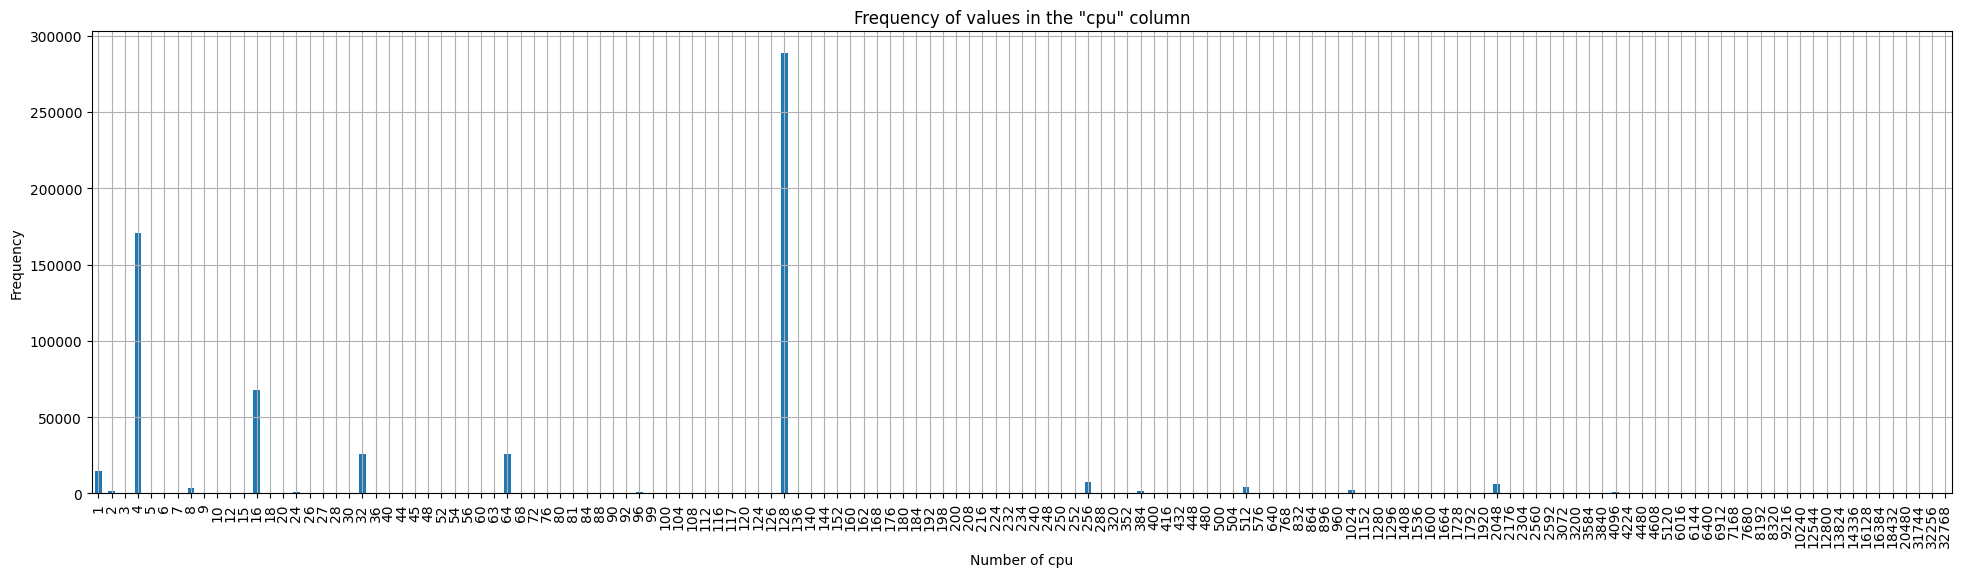

In [30]:
freq_cpu = df['cpu'].value_counts().sort_index()

freq_cpu.plot(kind='bar', figsize=(24, 6))
plt.title('Frequency of values in the "cpu" column')
plt.xlabel('Number of cpu')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

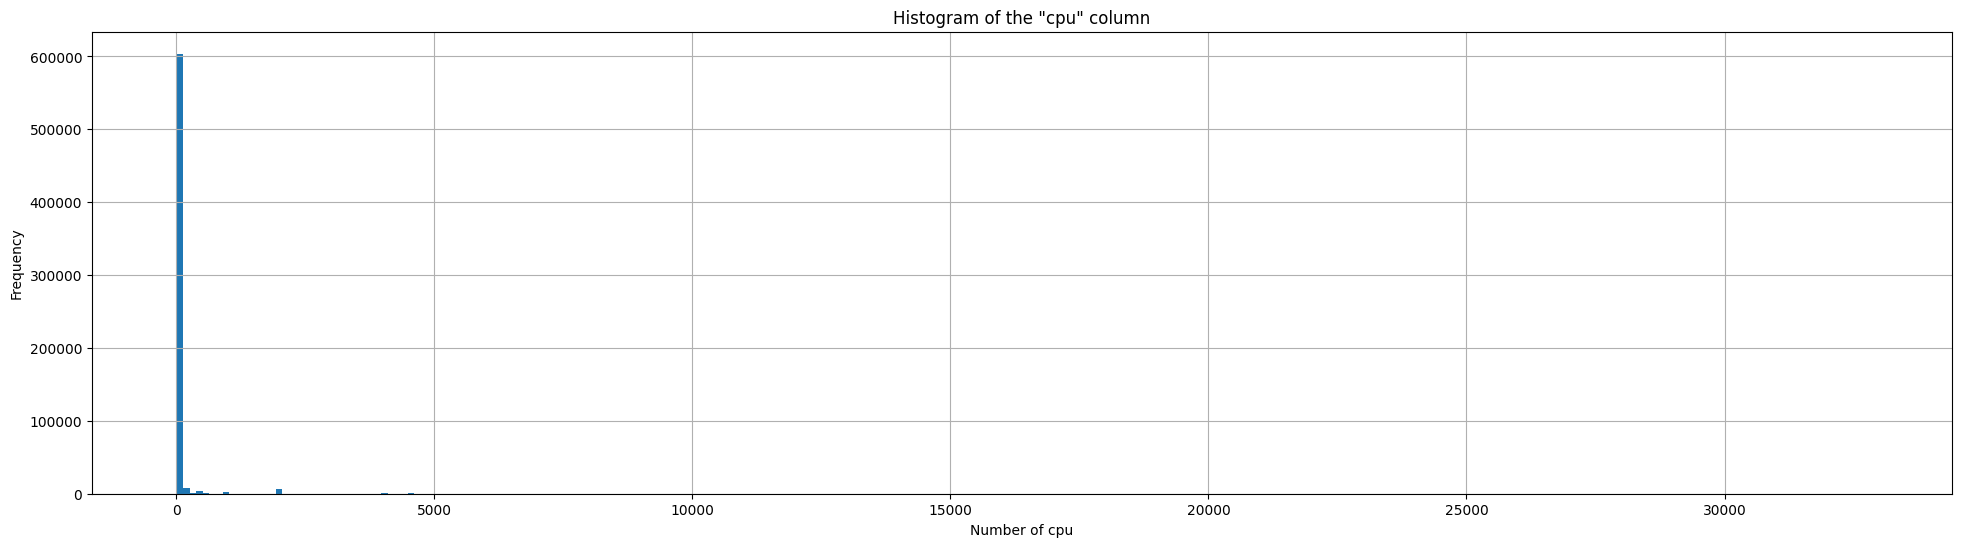

In [31]:
plt.figure(figsize=(24, 6))
plt.hist(df['cpu'], bins=256)
plt.title('Histogram of the "cpu" column')
plt.xlabel('Number of cpu')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [32]:
# plt.figure(figsize=(6, 10))
# plt.boxplot(df['cpu'])
# plt.title('Box plot of {"cpu"}')
# plt.show()

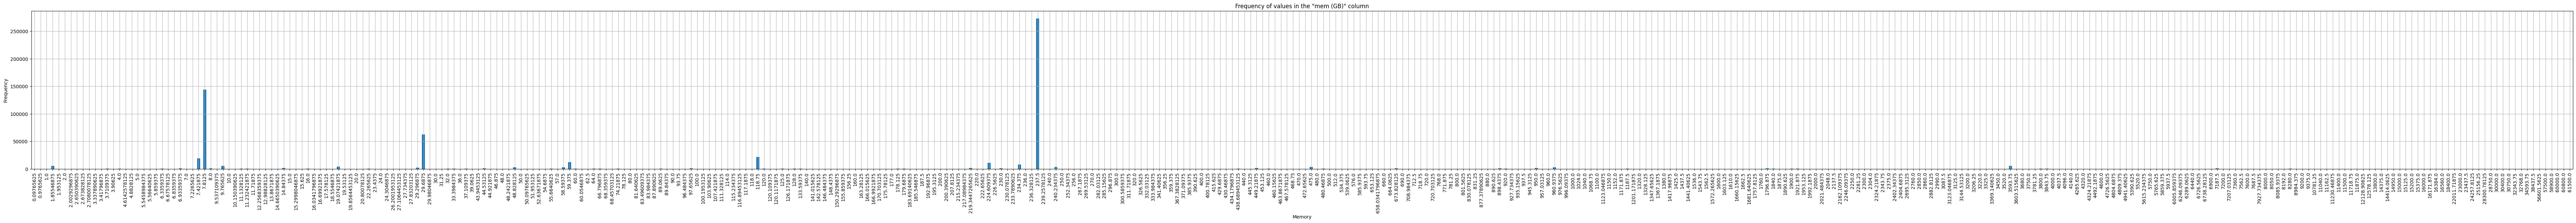

In [33]:
freq_mem = df['mem (GB)'].value_counts().sort_index()

freq_mem.plot(kind='bar', figsize=(96, 6))
plt.title('Frequency of values in the "mem (GB)" column')
plt.xlabel('Memory')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

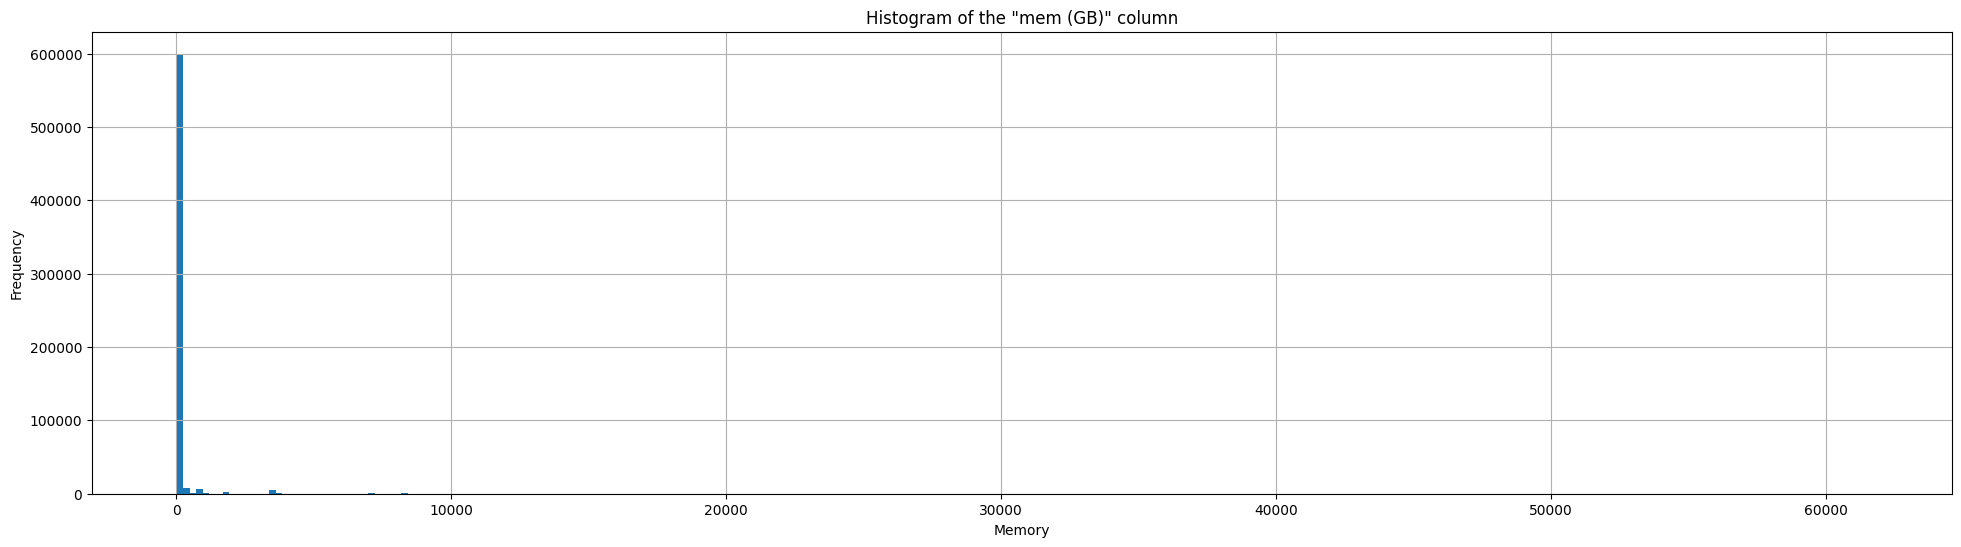

In [34]:
plt.figure(figsize=(24, 6))
plt.hist(df['mem (GB)'], bins=256)
plt.title('Histogram of the "mem (GB)" column')
plt.xlabel('Memory')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

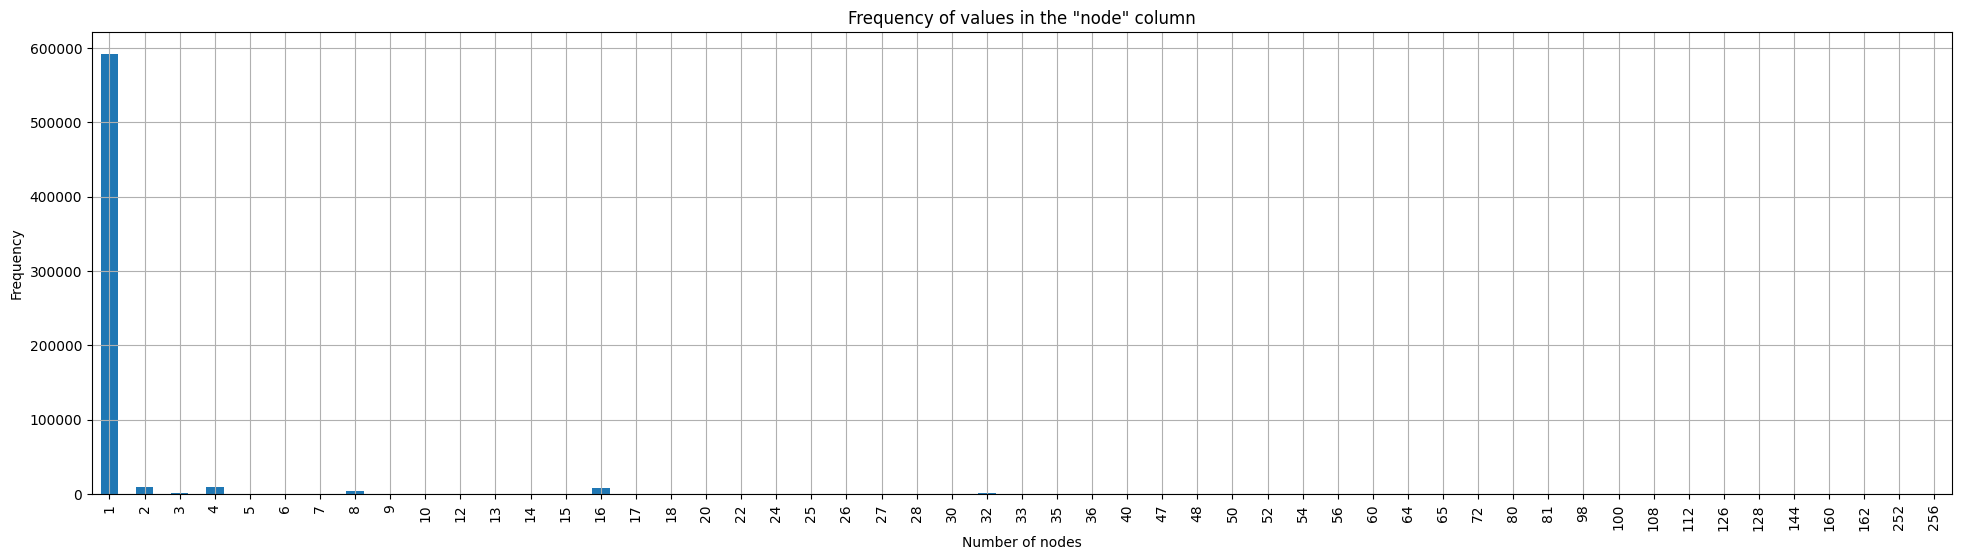

In [35]:
freq_node = df['node'].value_counts().sort_index()

freq_node.plot(kind='bar', figsize=(24, 6))
plt.title('Frequency of values in the "node" column')
plt.xlabel('Number of nodes')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

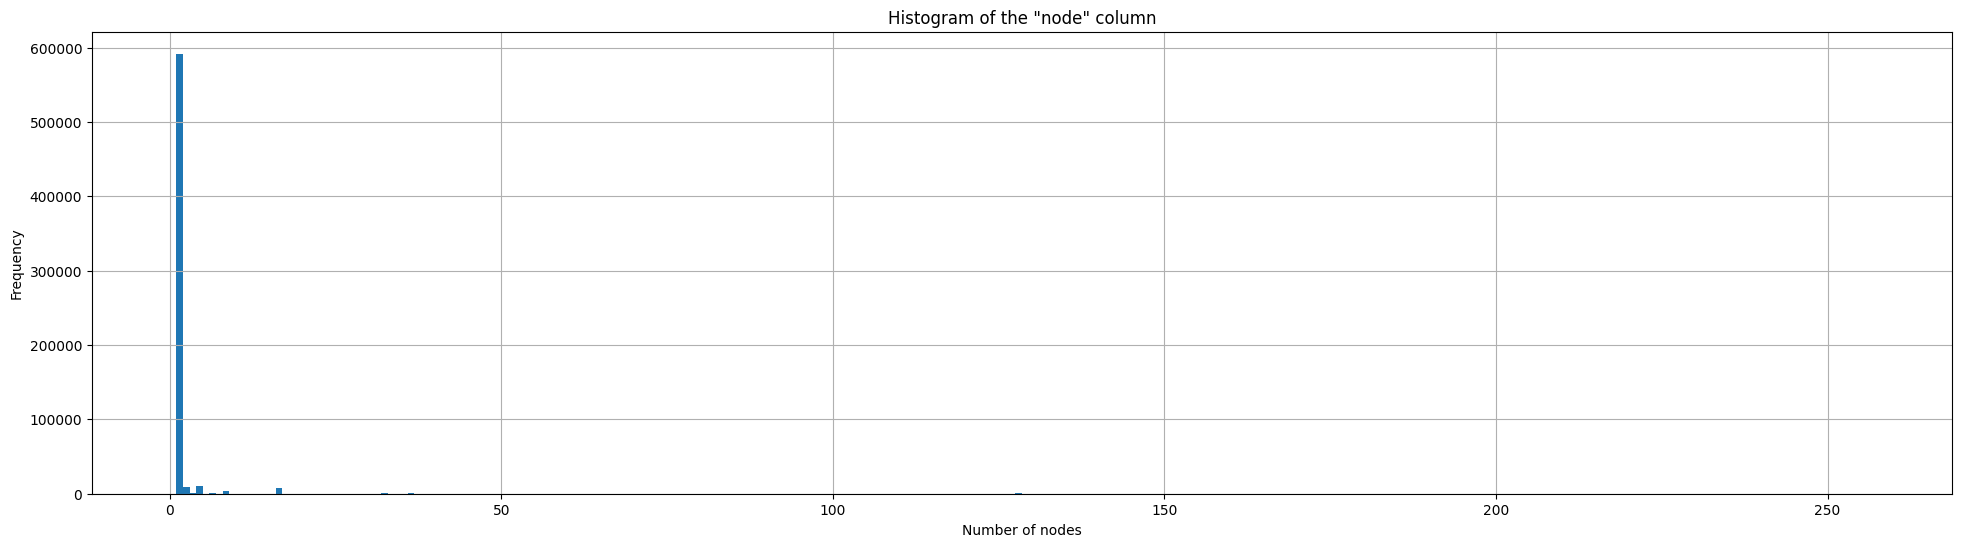

In [36]:
plt.figure(figsize=(24, 6))
plt.hist(df['node'], bins=256)
plt.title('Histogram of the "node" column')
plt.xlabel('Number of nodes')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

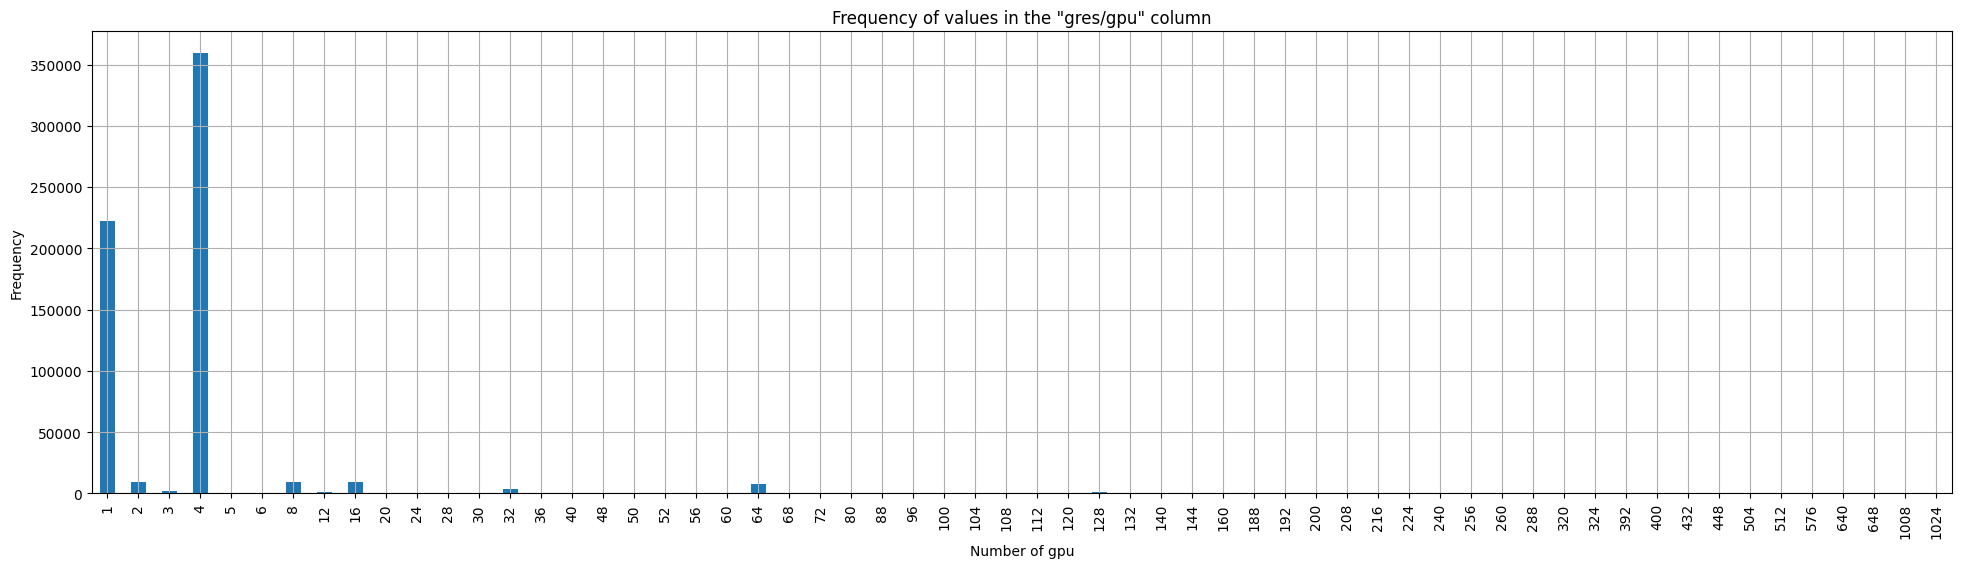

In [37]:
freq_gpu = df['gres/gpu'].value_counts().sort_index()

freq_gpu.plot(kind='bar', figsize=(24, 6))
plt.title('Frequency of values in the "gres/gpu" column')
plt.xlabel('Number of gpu')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

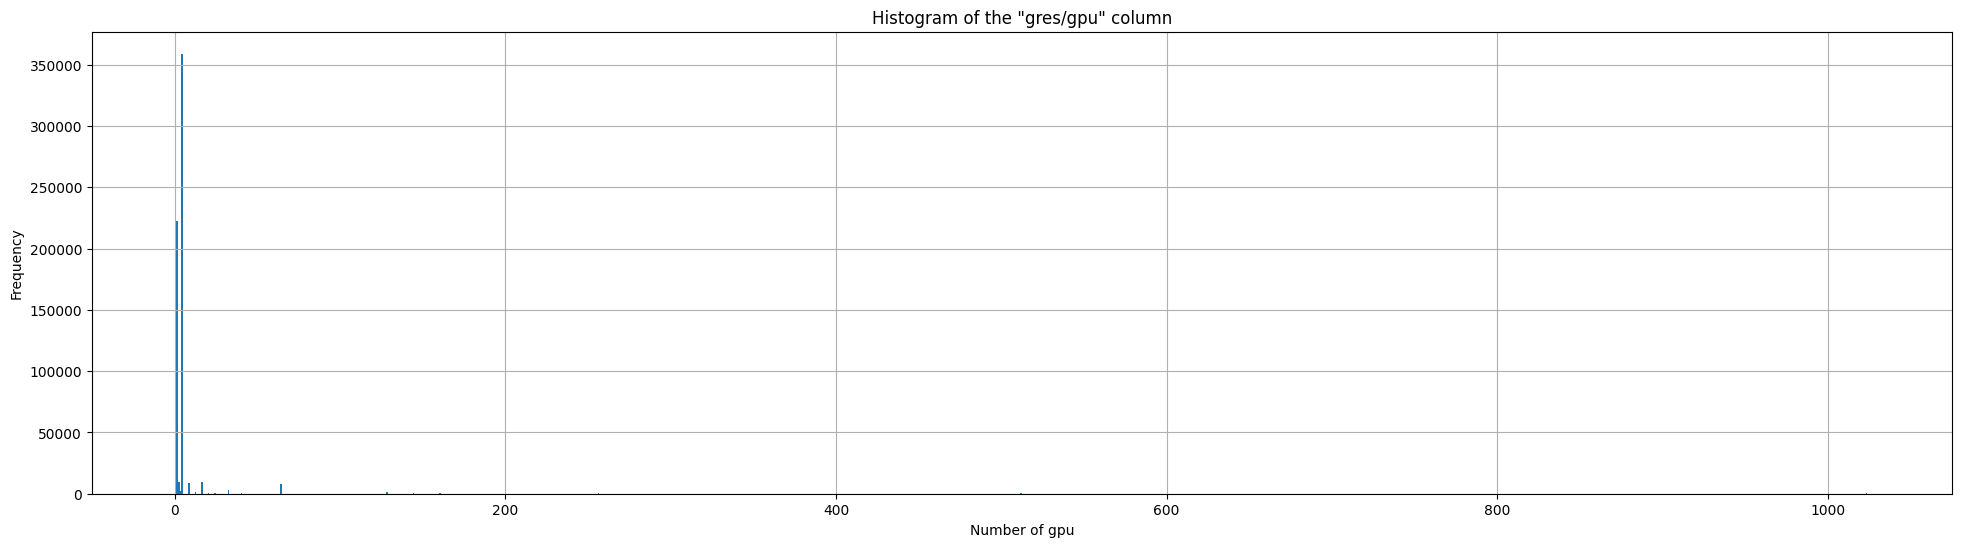

In [38]:
plt.figure(figsize=(24, 6))
plt.hist(df['gres/gpu'], bins=1024)
plt.title('Histogram of the "gres/gpu" column')
plt.xlabel('Number of gpu')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

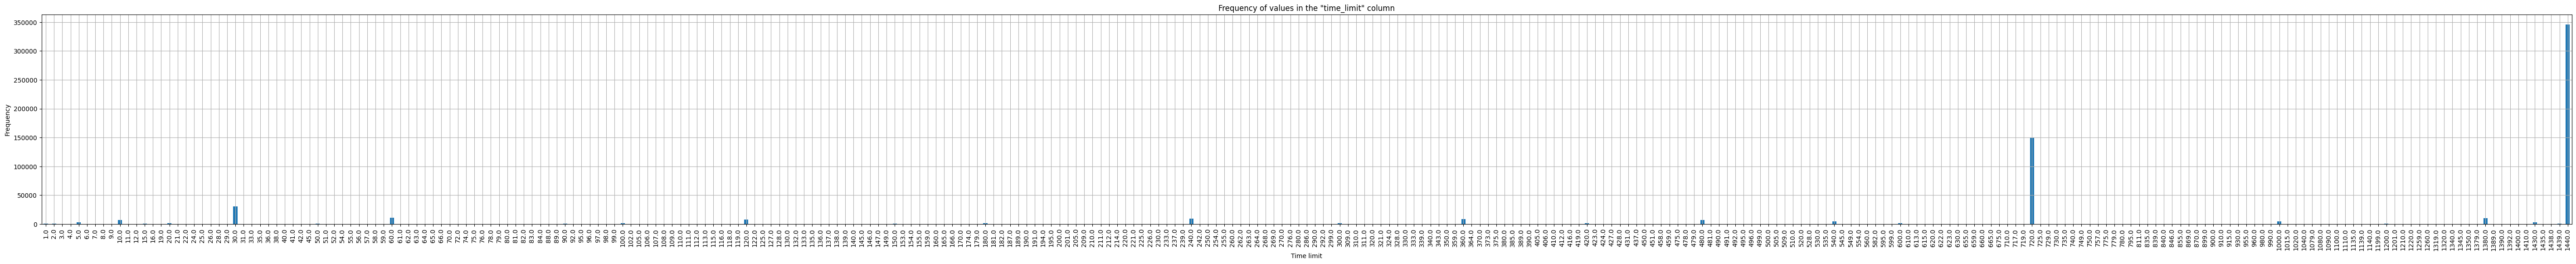

In [39]:
freq_tl = df['time_limit'].value_counts().sort_index()

freq_tl.plot(kind='bar', figsize=(72, 6))
plt.title('Frequency of values in the "time_limit" column')
plt.xlabel('Time limit')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

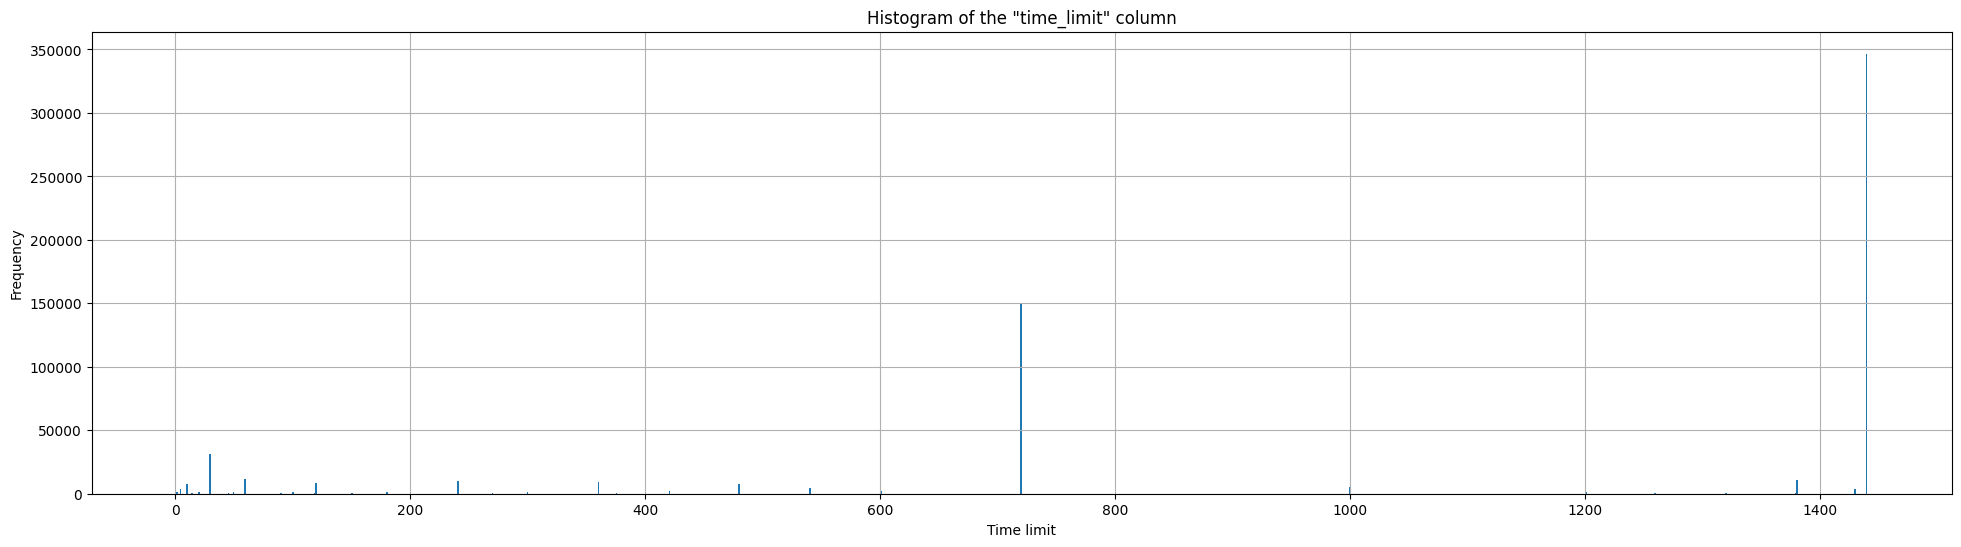

In [40]:
plt.figure(figsize=(24, 6))
plt.hist(df['time_limit'], bins=1024)
plt.title('Histogram of the "time_limit" column')
plt.xlabel('Time limit')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

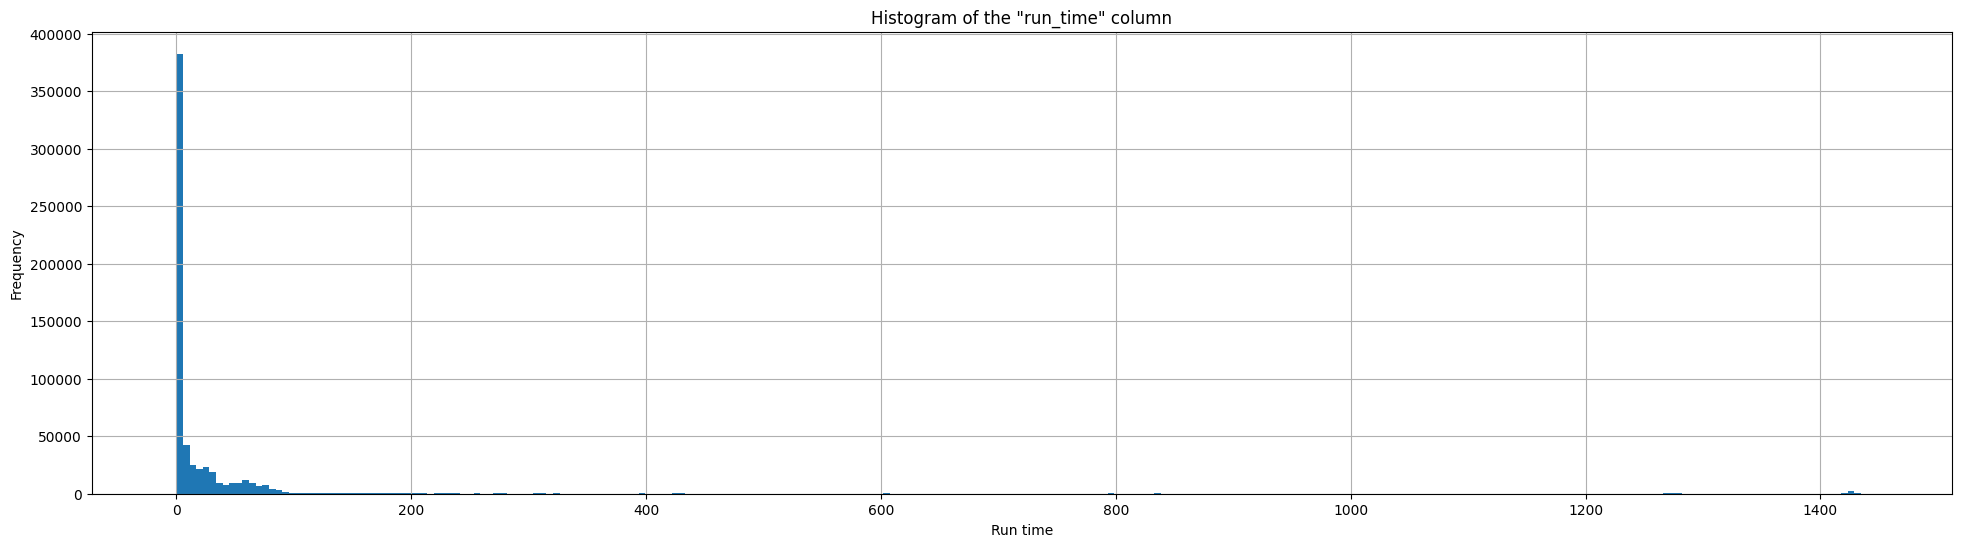

In [41]:
plt.figure(figsize=(24, 6))
plt.hist(df['run_time'], bins=256)
plt.title('Histogram of the "run_time" column')
plt.xlabel('Run time')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

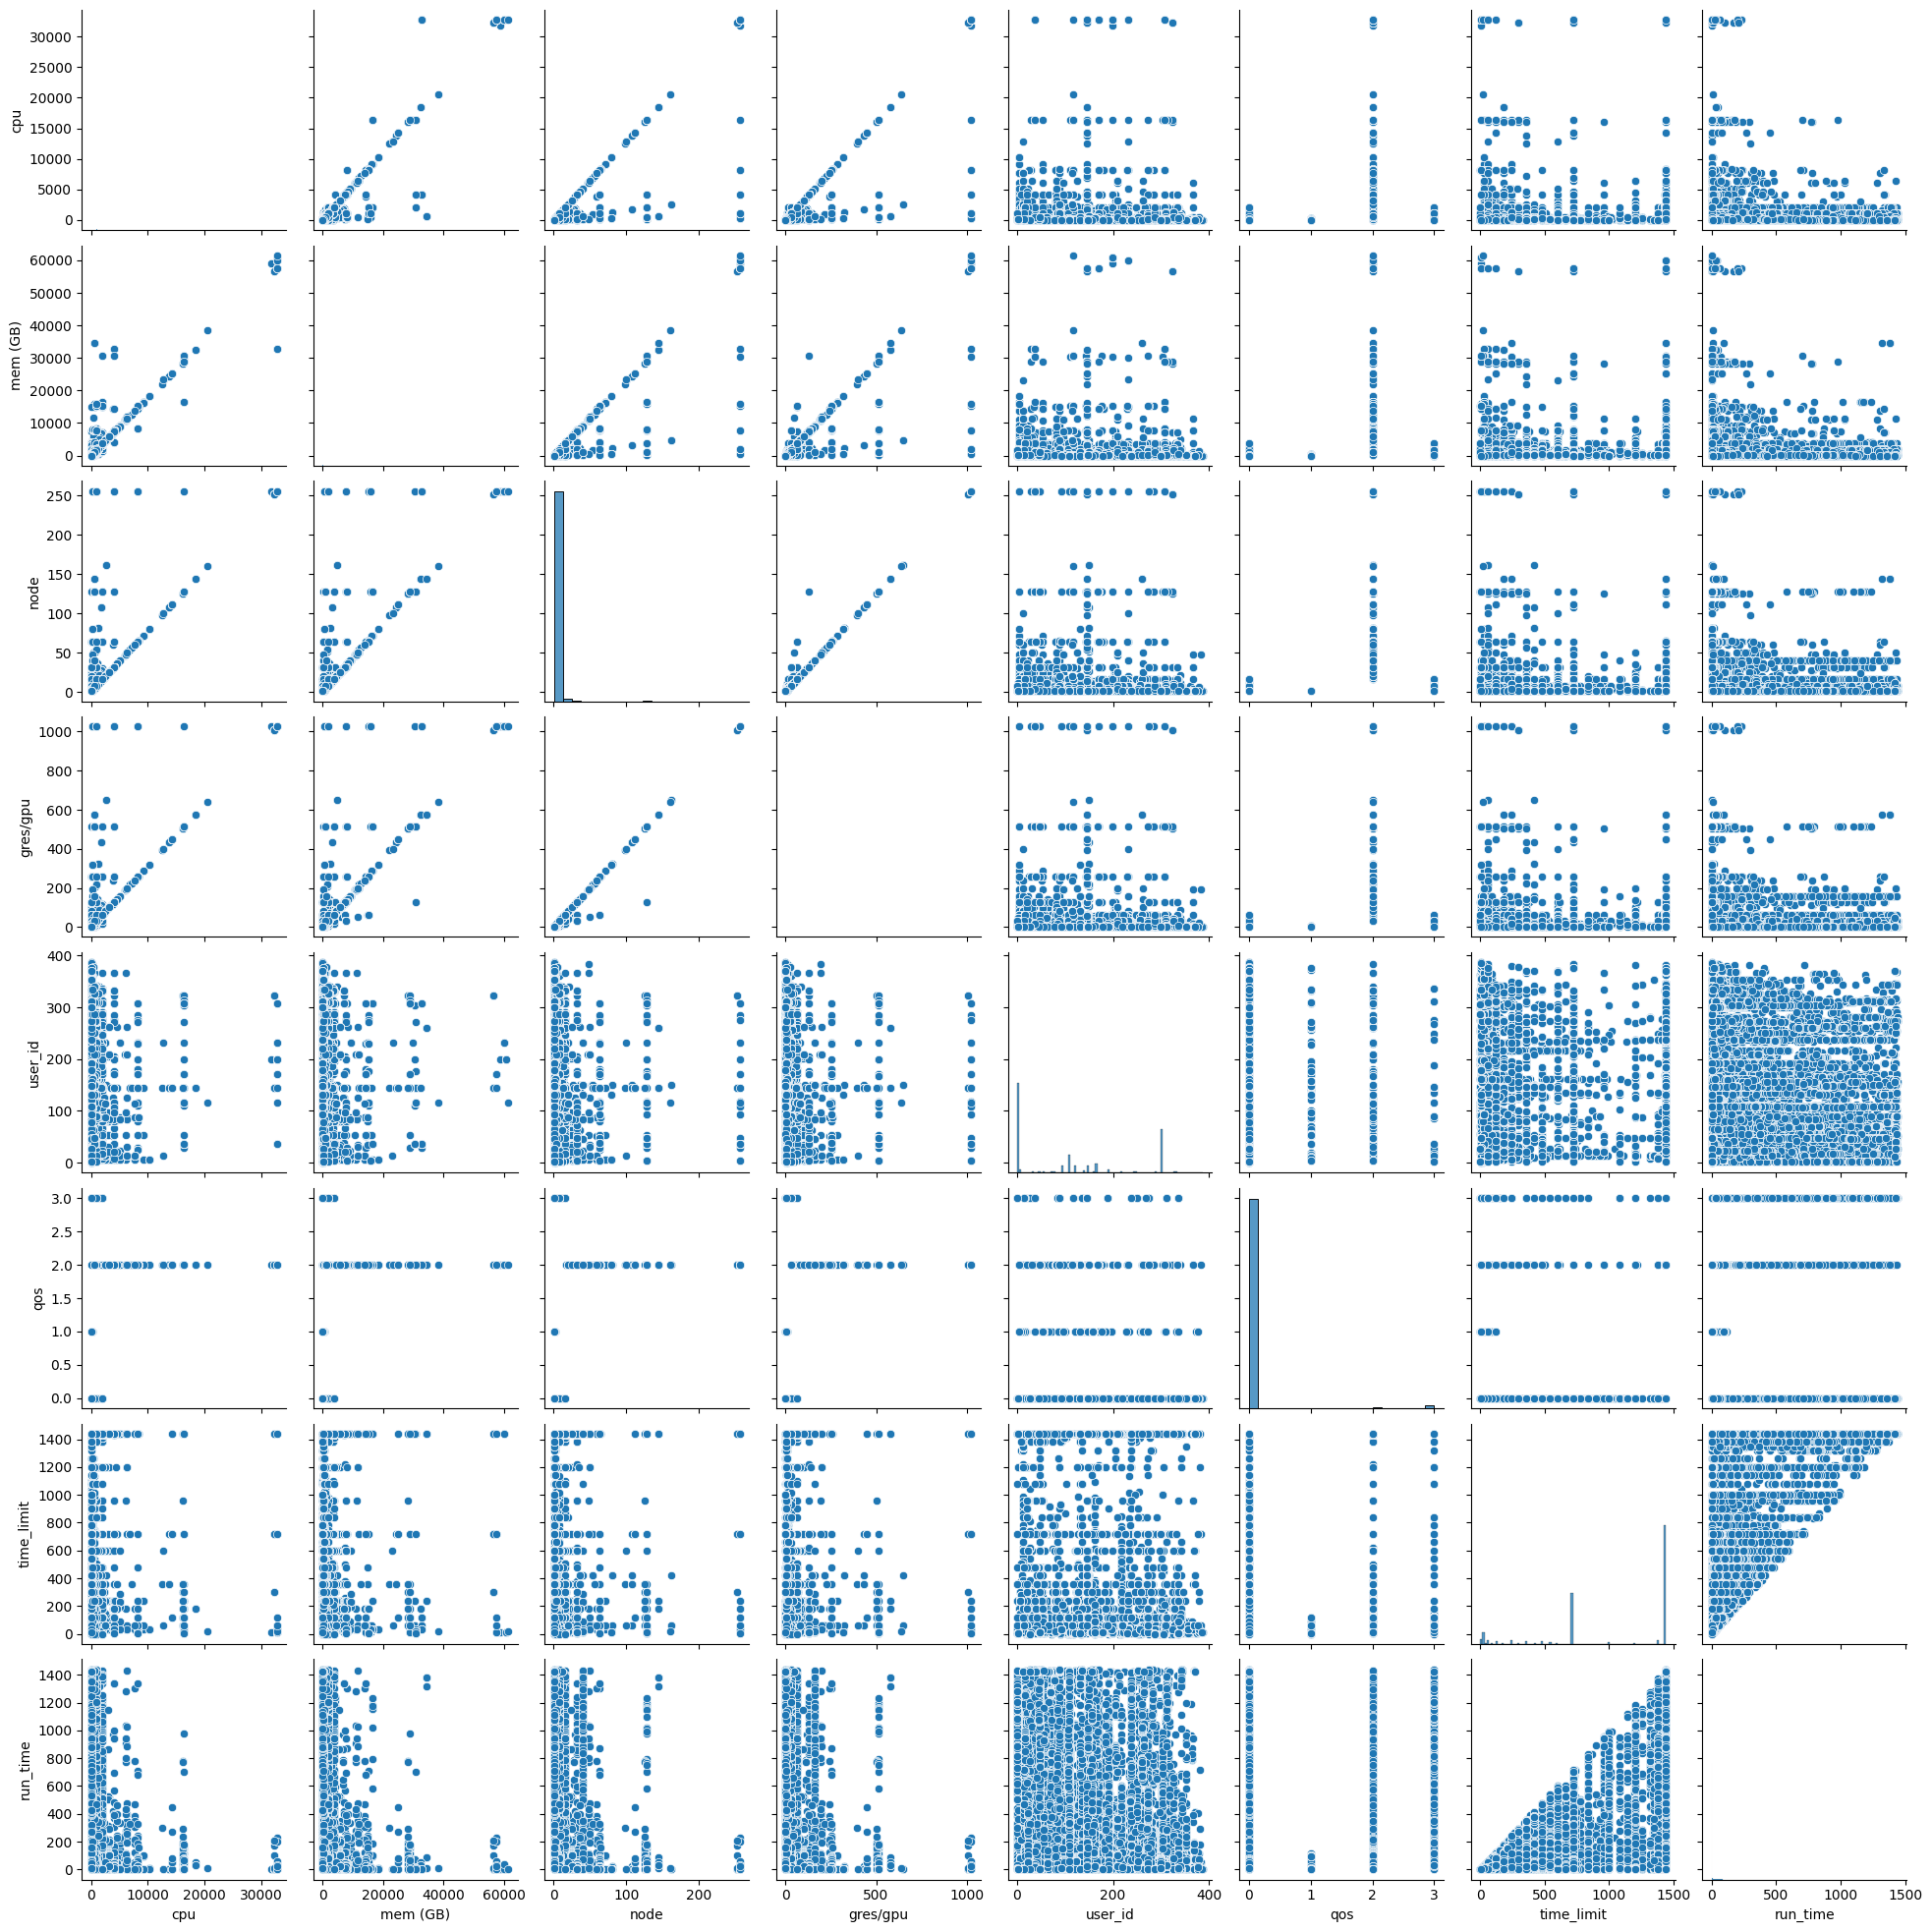

In [42]:
sns.pairplot(df)
plt.show()

In [ ]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
# REGRESSION MODELS
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [55]:
# Model 1: Decision Tree
def run_decision_tree(X_train, y_train):
    # Initialize and train the model
    dt_model = DecisionTreeRegressor(random_state=13)
    dt_model.fit(X_train, y_train)
    
    # Make prediction on the test set
    y_pred_dt = dt_model.predict(X_test)

    # Calculate the mean absolute error
    dt_mae = mean_absolute_error(y_test, y_pred_dt)
    print('Mean Absolute Error (Decision Tree): {:.2f}'.format(dt_mae))
    
    # Calculate the mean squared error
    dt_mse = mean_squared_error(y_test, y_pred_dt)
    print('Mean Squared Error (Decision Tree): {:.2f}'.format(dt_mse))
    
    # Calculate the root mean squared error
    dt_rmse = root_mean_squared_error(y_test, y_pred_dt)
    print('Root Mean Squared Error (Decision Tree): {:.2f}'.format(dt_rmse))
    
    # Calculate the R² score
    dt_r2 = r2_score(y_test, y_pred_dt)
    print('R² score (Decision Tree): {:.2f}'.format(dt_r2))
    
    # Pack for results analysis
    dt_prev = ('Decision Tree', y_pred_dt)
    dt_metrics = ('Decision Tree', '{:.2f}'.format(dt_mae), '{:.2f}'.format(dt_mse), '{:.2f}'.format(dt_rmse), '{:.2f}'.format(dt_r2))
    
    return y_pred_dt, dt_prev, dt_metrics

# Model 2: Random Forest
def run_random_forest(X_train, y_train):
    # Initialize and train the model
    rf_model = RandomForestRegressor(n_estimators=100, random_state=13)
    rf_model.fit(X_train, y_train)
    
    # Make prediction on the test set
    y_pred_rf = rf_model.predict(X_test)

    # Calculate the mean absolute error
    rf_mae = mean_absolute_error(y_test, y_pred_rf)
    print('Mean Absolute Error (Random Forest): {:.2f}'.format(rf_mae))
    
    # Calculate the mean squared error
    rf_mse = mean_squared_error(y_test, y_pred_rf)
    print('Mean Squared Error (Random Forest): {:.2f}'.format(rf_mse))
    
    # Calculate the root mean squared error
    rf_rmse = root_mean_squared_error(y_test, y_pred_rf)
    print('Root Mean Squared Error (Random Forest): {:.2f}'.format(rf_rmse))
    
    # Calculate the R² score
    rf_r2 = r2_score(y_test, y_pred_rf)
    print('R² score (Random Forest): {:.2f}'.format(rf_r2))
    
    # Pack for results analysis
    rf_prev = ('Random Forest', y_pred_rf)
    rf_metrics = ('Random Forest', '{:.2f}'.format(rf_mae), '{:.2f}'.format(rf_mse), '{:.2f}'.format(rf_rmse), '{:.2f}'.format(rf_r2))
    
    return y_pred_rf, rf_prev, rf_metrics 

# Model 3: Gradient Boosting
def run_gradient_boosting(X_train, y_train):
    # Initialize and train the model
    gb_model = GradientBoostingRegressor(n_estimators=100, random_state=13)
    gb_model.fit(X_train, y_train)
    
    # Make prediction on the test set
    y_pred_gb = gb_model.predict(X_test)
    
    # Calculate the mean absolute error
    gb_mae = mean_absolute_error(y_test, y_pred_gb)
    print('Mean Absolute Error (Gradient Boosting): {:.2f}'.format(gb_mae))
    
    # Calculate the mean squared error
    gb_mse = mean_squared_error(y_test, y_pred_gb)
    print('Mean Squared Error (Gradient Boosting): {:.2f}'.format(gb_mse))
    
    # Calculate the root mean squared error
    gb_rmse = root_mean_squared_error(y_test, y_pred_gb)
    print('Root Mean Squared Error (Gradient Boosting): {:.2f}'.format(gb_rmse))
    
    # Calculate the R² score
    gb_r2 = r2_score(y_test, y_pred_gb)
    print('R² score (Gradient Boosting): {:.2f}'.format(gb_r2))
    
    # Pack for results analysis
    gb_prev = ('Gradient Boosting', y_pred_gb)
    gb_metrics = ('Gradient Boosting', '{:.2f}'.format(gb_mae), '{:.2f}'.format(gb_mse), '{:.2f}'.format(gb_rmse), '{:.2f}'.format(gb_r2))
    
    return y_pred_gb, gb_prev, gb_metrics 

In [56]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
# EXPERIMENT 1: Basic regression
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [57]:
# Split data into features and target
X = df.drop(columns=['run_time'])
y = df['run_time']

In [58]:
X.head()

cpu    mem (GB)  node  gres/gpu  user_id  qos  time_limit
0    1    1.855469     1         4        0    0        10.0
1    1    1.855469     1         4        0    0        10.0
2    4    9.765625     1         1        1    0        60.0
3  128  237.500000     1         4        2    0      1440.0
4    1    1.855469     1         4        0    0        10.0

In [59]:
y.head()

0    0.083333
1    0.100000
2    0.100000
3    0.066667
4    0.100000
Name: run_time, dtype: float64

In [60]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

# Save for future analysis
true_values_1 = np.array(y_test)
initial_guesses_1 = np.array(X_test['time_limit'])

In [61]:
print(X_train.shape)

(440283, 7)


In [62]:
X_train.describe()

cpu       mem (GB)           node       gres/gpu  \
count  440283.000000  440283.000000  440283.000000  440283.000000   
mean      121.285900     235.692879       1.693295       5.631919   
std       542.113642     992.985549       6.982127      28.023347   
min         1.000000       0.097656       1.000000       1.000000   
25%         4.000000       7.812500       1.000000       1.000000   
50%        96.000000     230.000000       1.000000       4.000000   
75%       128.000000     237.500000       1.000000       4.000000   
max     32768.000000   61500.000000     256.000000    1024.000000   

             user_id            qos     time_limit  
count  440283.000000  440283.000000  440283.000000  
mean      110.726717       0.051844    1038.058228  
std       118.514229       0.370619     506.503001  
min         0.000000       0.000000       1.000000  
25%         2.000000       0.000000     720.000000  
50%        93.000000       0.000000    1440.000000  
75%       191.000000       0.000000    1440.000000  
max       387.000000       3.000000    1440.000000

In [63]:
X_test.describe()

cpu       mem (GB)           node       gres/gpu  \
count  188694.000000  188694.000000  188694.000000  188694.000000   
mean      121.597226     236.943662       1.693016       5.624816   
std       557.114488    1044.108334       6.909900      27.700466   
min         1.000000       0.097656       1.000000       1.000000   
25%         4.000000       7.812500       1.000000       1.000000   
50%        64.000000     230.000000       1.000000       4.000000   
75%       128.000000     237.500000       1.000000       4.000000   
max     32768.000000   60800.000000     256.000000    1024.000000   

             user_id            qos     time_limit  
count  188694.000000  188694.000000  188694.000000  
mean      111.286851       0.049445    1038.093368  
std       118.779380       0.361118     505.888421  
min         0.000000       0.000000       1.000000  
25%         2.000000       0.000000     720.000000  
50%        93.000000       0.000000    1440.000000  
75%       191.000000       0.000000    1440.000000  
max       386.000000       3.000000    1440.000000

In [64]:
# Model 1: Decision Tree
y_pred_dt, dt_prev, dt_metrics = run_decision_tree(X_train, y_train)

Mean Absolute Error (Decision Tree): 23.56
Mean Squared Error (Decision Tree): 8052.40
Root Mean Squared Error (Decision Tree): 89.74
R² score (Decision Tree): 0.72


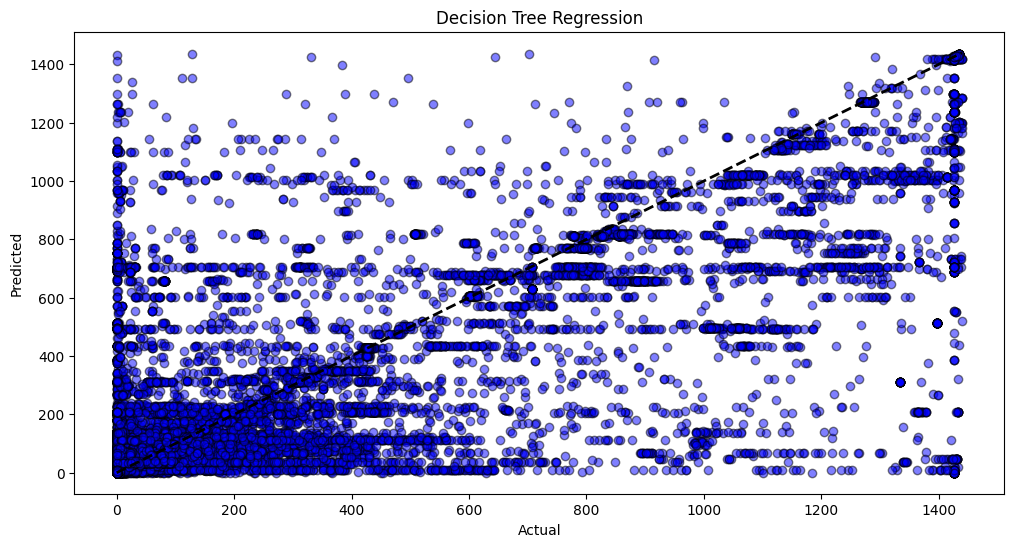

In [65]:
plot_regression(y_test, y_pred_dt, 'blue', 'Decision Tree Regression')

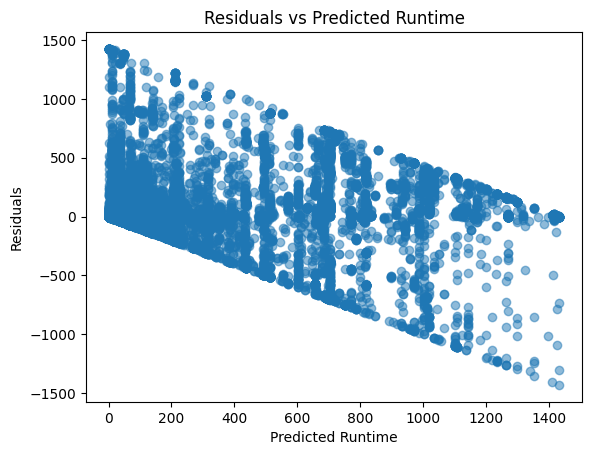

In [66]:
plot_residuals(y_test, y_pred_dt)

In [69]:
# Model 2: Random Forest
y_pred_rf, rf_prev, rf_metrics = run_random_forest(X_train, y_train)

Mean Absolute Error (Random Forest): 23.58
Mean Squared Error (Random Forest): 7990.01
Root Mean Squared Error (Random Forest): 89.39
R² score (Random Forest): 0.72


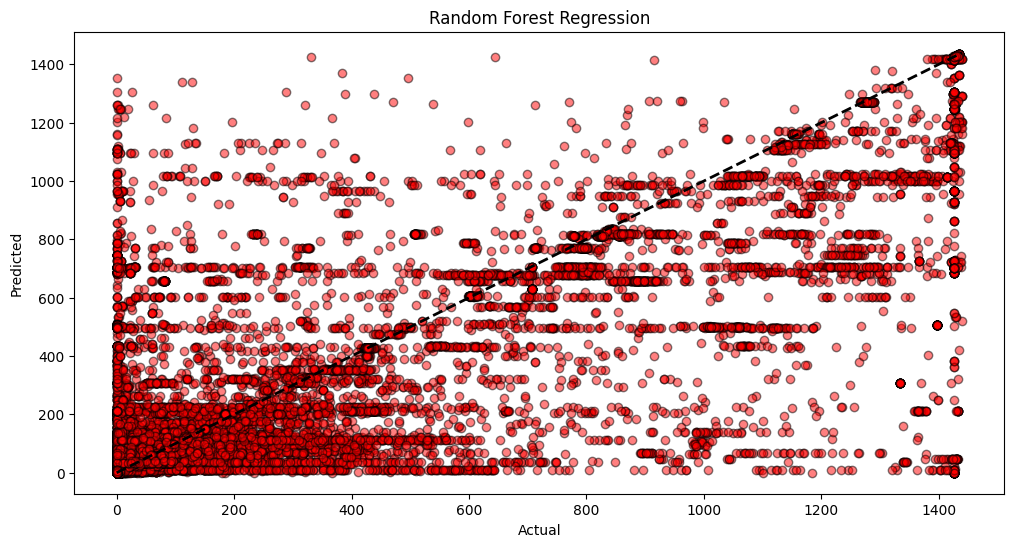

In [70]:
plot_regression(y_test, y_pred_rf, 'red', 'Random Forest Regression')

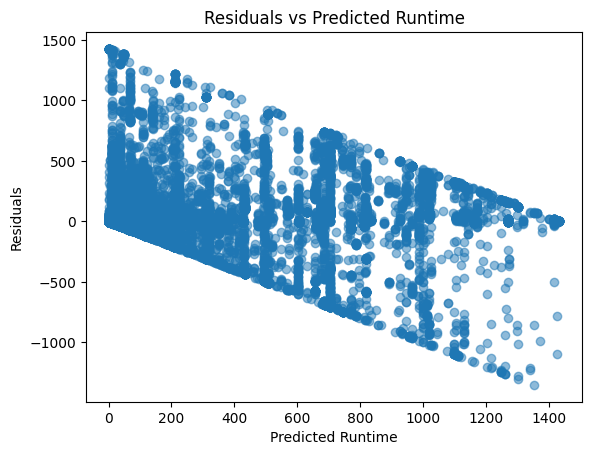

In [71]:
plot_residuals(y_test, y_pred_rf)

In [72]:
# Model 3: Gradient Boosting
y_pred_gb, gb_prev, gb_metrics = run_gradient_boosting(X_train, y_train)

Mean Absolute Error (Gradient Boosting): 35.89
Mean Squared Error (Gradient Boosting): 13146.85
Root Mean Squared Error (Gradient Boosting): 114.66
R² score (Gradient Boosting): 0.54


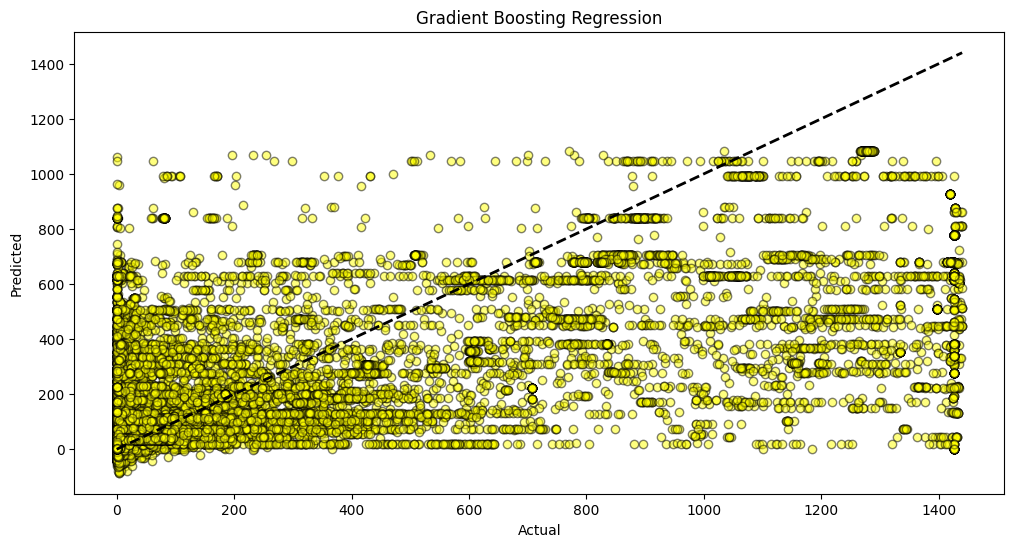

In [73]:
plot_regression(y_test, y_pred_gb, 'yellow', 'Gradient Boosting Regression')

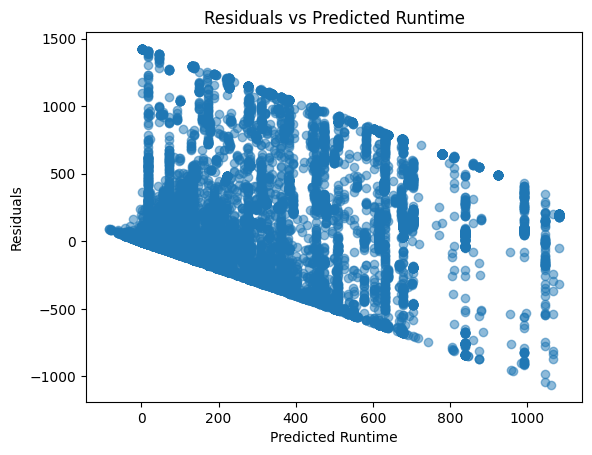

In [74]:
plot_residuals(y_test, y_pred_gb)

In [76]:
# Results Analysis

In [77]:
metrics_1 = [dt_metrics, rf_metrics, gb_metrics]
print(tabulate(metrics_1, headers=['MODEL', 'MAE', 'MSE', 'RMSE', 'R²'], tablefmt="heavy_grid", stralign="center", numalign="center"))

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┓
┃       MODEL       ┃  MAE  ┃   MSE   ┃  RMSE  ┃  R²  ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━╋━━━━━━━━━╋━━━━━━━━╋━━━━━━┫
┃   Decision Tree   ┃ 23.56 ┃ 8052.4  ┃ 89.74  ┃ 0.72 ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━╋━━━━━━━━━╋━━━━━━━━╋━━━━━━┫
┃   Random Forest   ┃ 23.58 ┃ 7990.01 ┃ 89.39  ┃ 0.72 ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━╋━━━━━━━━━╋━━━━━━━━╋━━━━━━┫
┃ Gradient Boosting ┃ 35.89 ┃ 13146.9 ┃ 114.66 ┃ 0.54 ┃
┗━━━━━━━━━━━━━━━━━━━┻━━━━━━━┻━━━━━━━━━┻━━━━━━━━┻━━━━━━┛


In [79]:
previsions_1 = (dt_prev, rf_prev, gb_prev)
evaluate_models(previsions_1, true_values_1)

The model "Decision Tree":
   - Overestimates the runtime in 79.50% of the cases (150019 out of 188694)
       • min(error)=0.01 ; max(error)=1431.00 ; avg(error)=14.82
       • The error is less than one hour in 96.30% of the cases (144461 out of 150019)
   - Underestimates the runtime in 20.00% of the cases (37735 out of 188694)
       • min(error)=0.01 ; max(error)=1425.53 ; avg(error)=58.91
       • The error is less than one hour in 86.67% of the cases (32704 out of 37735)
   - Exactly predict the runtime in the 0.50% of the cases (940 out of 188694)

The model "Random Forest":
   - Overestimates the runtime in 79.64% of the cases (150280 out of 188694)
       • min(error)=0.01 ; max(error)=1351.29 ; avg(error)=14.78
       • The error is less than one hour in 96.23% of the cases (144610 out of 150280)
   - Underestimates the runtime in 19.89% of the cases (37529 out of 188694)
       • min(error)=0.01 ; max(error)=1425.54 ; avg(error)=59.35
       • The error is less than one hou

In [80]:
compare_previsions(previsions_1, initial_guesses_1, true_values_1)

The model "Decision Tree":
   - In general, is more effective at approximating the actual "run_time" with respect to "time_limit" by 78.10%
   - In particular, for valid predictions (when it does not underestimate the actual "run_time"), it is more effective by 97.93%

The model "Random Forest":
   - In general, is more effective at approximating the actual "run_time" with respect to "time_limit" by 78.26%
   - In particular, for valid predictions (when it does not underestimate the actual "run_time"), it is more effective by 97.94%

The model "Gradient Boosting":
   - In general, is more effective at approximating the actual "run_time" with respect to "time_limit" by 75.86%
   - In particular, for valid predictions (when it does not underestimate the actual "run_time"), it is more effective by 96.13%



In [81]:
get_confidence_intervals(previsions_1)

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       MODEL       ┃  CONFIDENCE INTERVAL (95%)  ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃   Decision Tree   ┃       [0.00, 326.96]        ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃   Random Forest   ┃       [0.00, 325.80]        ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃ Gradient Boosting ┃       [0.00, 259.85]        ┃
┗━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [82]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
# EXPERIMENT 2: Let's try to partition the dataframe by account/user to see if considering only a subset of the "best accounts"/"best users" gives us better results
# The assumption is that more experienced users (i.e. those who have submitted more jobs) will be better able to give useful information at submission time.
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [83]:
# Reset df
df = reset_df(df1)
df.head()

cpu    mem (GB)  node  gres/gpu  user_id  qos  time_limit  run_time
0    1    1.855469     1         4        0    0        10.0  0.083333
1    1    1.855469     1         4        0    0        10.0  0.100000
2    4    9.765625     1         1        1    0        60.0  0.100000
3  128  237.500000     1         4        2    0      1440.0  0.066667
4    1    1.855469     1         4        0    0        10.0  0.100000

In [84]:
# For this purpose, we firts calculate the average number of jobs per user and only consider users who have submitted at least 10% of the average number of jobs.
# target = 'account'
target = 'user_id'

jobs_per_user = df[target].value_counts()
job_threshold = np.floor(jobs_per_user.mean() / 10).astype(int)
users_above_threshold = jobs_per_user[jobs_per_user > job_threshold]
print(len(users_above_threshold), 'out of', df[target].unique().size, 'users have submitted more than', job_threshold, 'jobs')

126 out of 388 users have submitted more than 162 jobs


In [85]:
users_metrics = []

for t in df[target].unique():

    df_part = df[df[target]==t]
    
    if df_part.shape[0] > job_threshold:
        
        X = df_part.drop(columns=['run_time'])
        y = df_part['run_time']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)
        
        dt_model = DecisionTreeRegressor(random_state=13)
        dt_model.fit(X_train, y_train)
    
        y_pred_dt = dt_model.predict(X_test)
        
        dt_mae = mean_absolute_error(y_test, y_pred_dt)
        dt_mse = mean_squared_error(y_test, y_pred_dt)
        dt_rmse = root_mean_squared_error(y_test, y_pred_dt)
        dt_r2 = r2_score(y_test, y_pred_dt)

        users_metrics.append((t, dt_mae, dt_mse, dt_rmse, dt_r2))

In [86]:
best_users = []
n_users = 50
for a in sorted(users_metrics, key=lambda x: x[2], reverse=False):
    if len(best_users) <= n_users:
        best_users.append(a[0])

In [89]:
df_best = df[df[target].isin(best_users)]

print('Experimental pool:\n')
print(' - {} out of {} {} ({:.2f}%)'.format(n_users, df[target].unique().size, target, n_users/df[target].unique().size*100))
print(' - {} out of {} jobs ({:.2f})%'.format(df_best.shape[0], df.shape[0], df_best.shape[0]/df.shape[0]*100))

X = df_best.drop(columns=['run_time'])
y = df_best['run_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

true_values_2 = np.array(y_test)
initial_guesses_2 = np.array(X_test['time_limit'])

Experimental pool:

 - 50 out of 388 user_id (12.89%)
 - 497894 out of 628977 jobs (79.16)%


In [90]:
# Model 1: Decision Tree
y_pred_dt, dt_prev, dt_metrics = run_decision_tree(X_train, y_train)

Mean Absolute Error (Decision Tree): 8.43
Mean Squared Error (Decision Tree): 872.37
Root Mean Squared Error (Decision Tree): 29.54
R² score (Decision Tree): 0.78


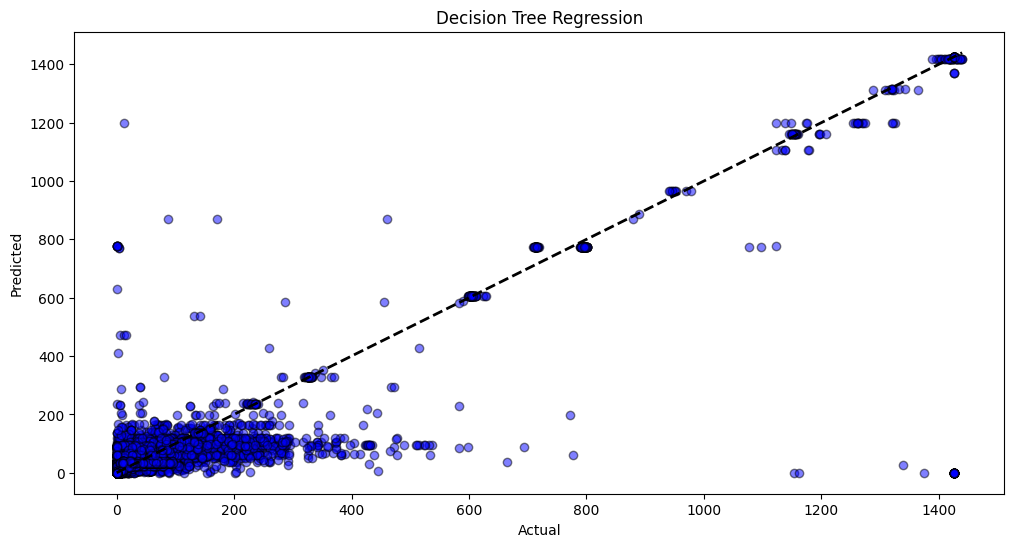

In [91]:
plot_regression(y_test, y_pred_dt, 'blue', 'Decision Tree Regression')

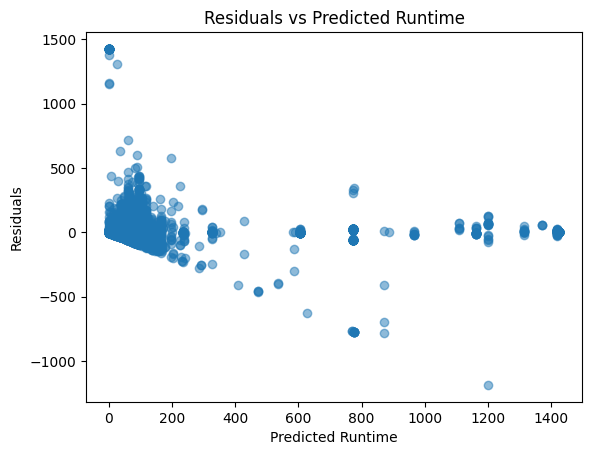

In [92]:
plot_residuals(y_test, y_pred_dt)

In [93]:
# Model 2: Random Forest
y_pred_rf, rf_prev, rf_metrics = run_random_forest(X_train, y_train)

Mean Absolute Error (Random Forest): 8.42
Mean Squared Error (Random Forest): 855.53
Root Mean Squared Error (Random Forest): 29.25
R² score (Random Forest): 0.78


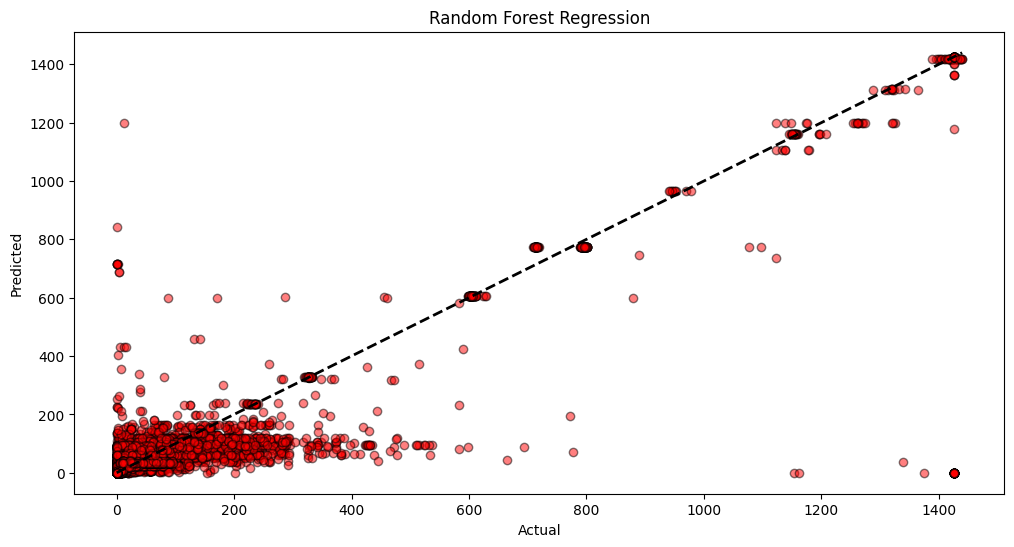

In [94]:
plot_regression(y_test, y_pred_rf, 'red', 'Random Forest Regression')

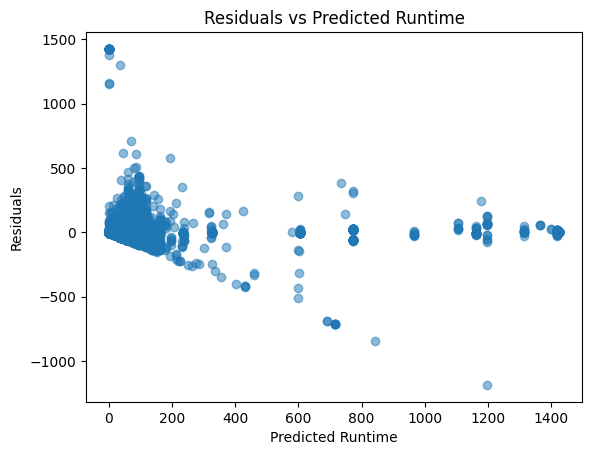

In [95]:
plot_residuals(y_test, y_pred_rf)

In [96]:
# Model 3: Gradient Boosting
y_pred_gb, gb_prev, gb_metrics = run_gradient_boosting(X_train, y_train)

Mean Absolute Error (Gradient Boosting): 10.16
Mean Squared Error (Gradient Boosting): 1176.66
Root Mean Squared Error (Gradient Boosting): 34.30
R² score (Gradient Boosting): 0.70


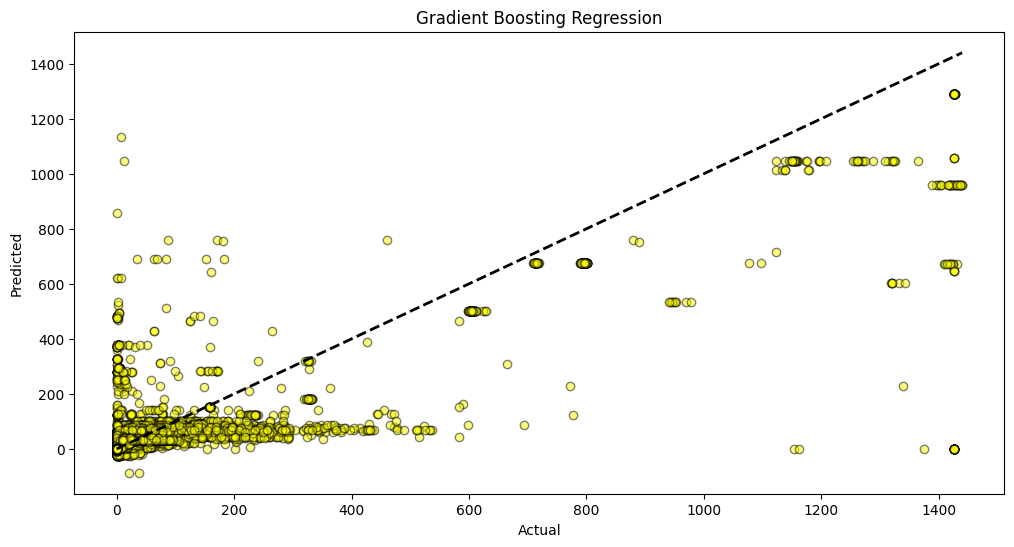

In [97]:
plot_regression(y_test, y_pred_gb, 'yellow', 'Gradient Boosting Regression')

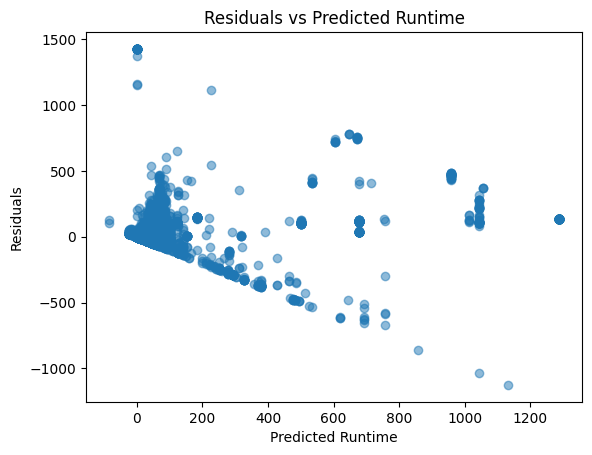

In [98]:
plot_residuals(y_test, y_pred_gb)

In [99]:
metrics_2 = [dt_metrics, rf_metrics, gb_metrics]
print(tabulate(metrics_2, headers=['MODEL', 'MAE', 'MSE', 'RMSE', 'R²'], tablefmt="heavy_grid", stralign="center", numalign="center"))

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┓
┃       MODEL       ┃  MAE  ┃   MSE   ┃  RMSE  ┃  R²  ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━╋━━━━━━━━━╋━━━━━━━━╋━━━━━━┫
┃   Decision Tree   ┃ 8.43  ┃ 872.37  ┃ 29.54  ┃ 0.78 ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━╋━━━━━━━━━╋━━━━━━━━╋━━━━━━┫
┃   Random Forest   ┃ 8.42  ┃ 855.53  ┃ 29.25  ┃ 0.78 ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━╋━━━━━━━━━╋━━━━━━━━╋━━━━━━┫
┃ Gradient Boosting ┃ 10.16 ┃ 1176.66 ┃  34.3  ┃ 0.7  ┃
┗━━━━━━━━━━━━━━━━━━━┻━━━━━━━┻━━━━━━━━━┻━━━━━━━━┻━━━━━━┛


In [100]:
previsions_2 = (dt_prev, rf_prev, gb_prev)
evaluate_models(previsions_2, true_values_2)

The model "Decision Tree":
   - Overestimates the runtime in 80.14% of the cases (119703 out of 149369)
       • min(error)=0.01 ; max(error)=1187.33 ; avg(error)=5.31
       • The error is less than one hour in 99.88% of the cases (119561 out of 119703)
   - Underestimates the runtime in 19.35% of the cases (28910 out of 149369)
       • min(error)=0.01 ; max(error)=1425.49 ; avg(error)=21.59
       • The error is less than one hour in 98.23% of the cases (28397 out of 28910)
   - Exactly predict the runtime in the 0.51% of the cases (756 out of 149369)

The model "Random Forest":
   - Overestimates the runtime in 80.19% of the cases (119777 out of 149369)
       • min(error)=0.01 ; max(error)=1185.45 ; avg(error)=5.28
       • The error is less than one hour in 99.87% of the cases (119617 out of 119777)
   - Underestimates the runtime in 19.31% of the cases (28848 out of 149369)
       • min(error)=0.01 ; max(error)=1425.50 ; avg(error)=21.66
       • The error is less than one hour 

In [101]:
compare_previsions(previsions_2, initial_guesses_2, true_values_2)

The model "Decision Tree":
   - In general, is more effective at approximating the actual "run_time" with respect to "time_limit" by 79.38%
   - In particular, for valid predictions (when it does not underestimate the actual "run_time"), it is more effective by 98.72%

The model "Random Forest":
   - In general, is more effective at approximating the actual "run_time" with respect to "time_limit" by 79.43%
   - In particular, for valid predictions (when it does not underestimate the actual "run_time"), it is more effective by 98.72%

The model "Gradient Boosting":
   - In general, is more effective at approximating the actual "run_time" with respect to "time_limit" by 77.94%
   - In particular, for valid predictions (when it does not underestimate the actual "run_time"), it is more effective by 97.88%



In [102]:
get_confidence_intervals(previsions_2)

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       MODEL       ┃  CONFIDENCE INTERVAL (95%)  ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃   Decision Tree   ┃       [0.00, 127.69]        ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃   Random Forest   ┃       [0.00, 127.11]        ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃ Gradient Boosting ┃       [0.00, 111.29]        ┃
┗━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


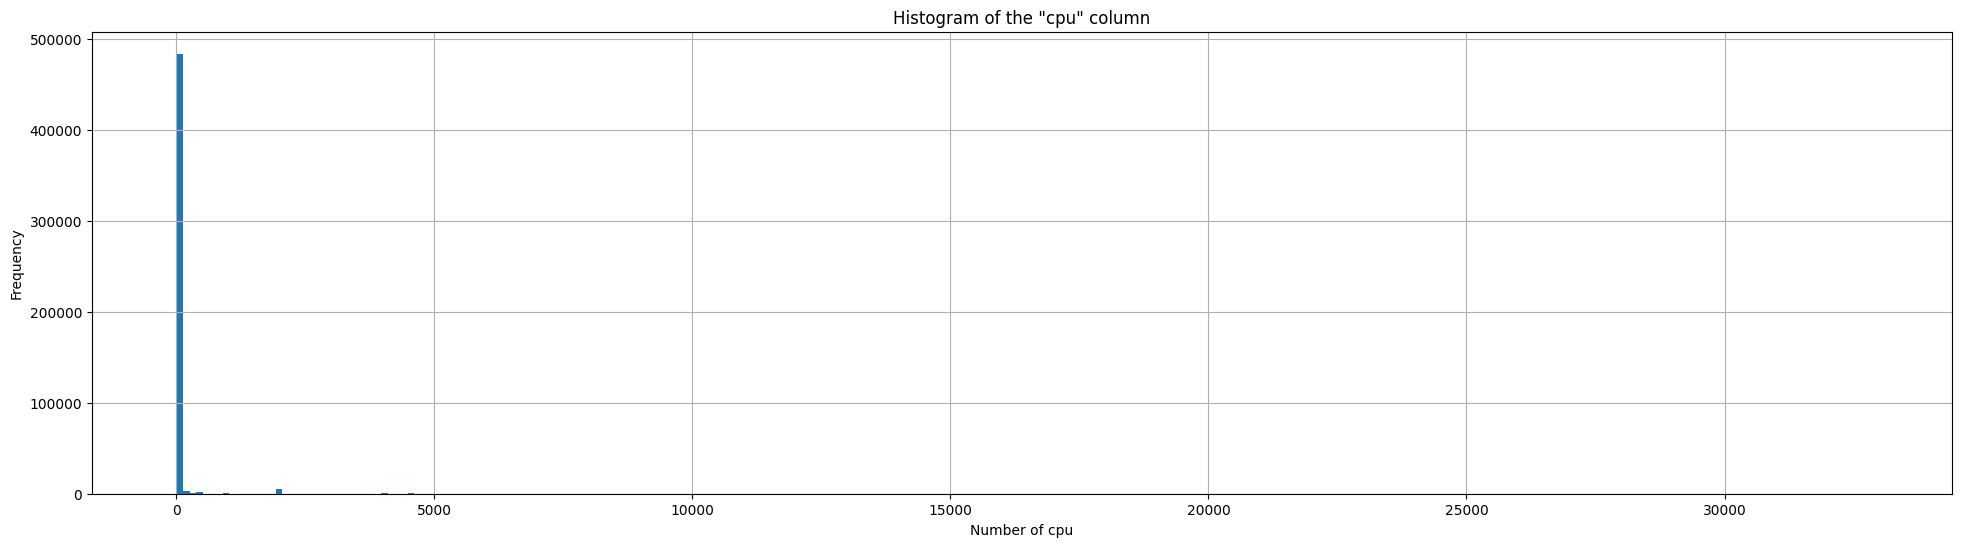

In [103]:
plt.figure(figsize=(24, 6))
plt.hist(df_best['cpu'], bins=256)
plt.title('Histogram of the "cpu" column')
plt.xlabel('Number of cpu')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

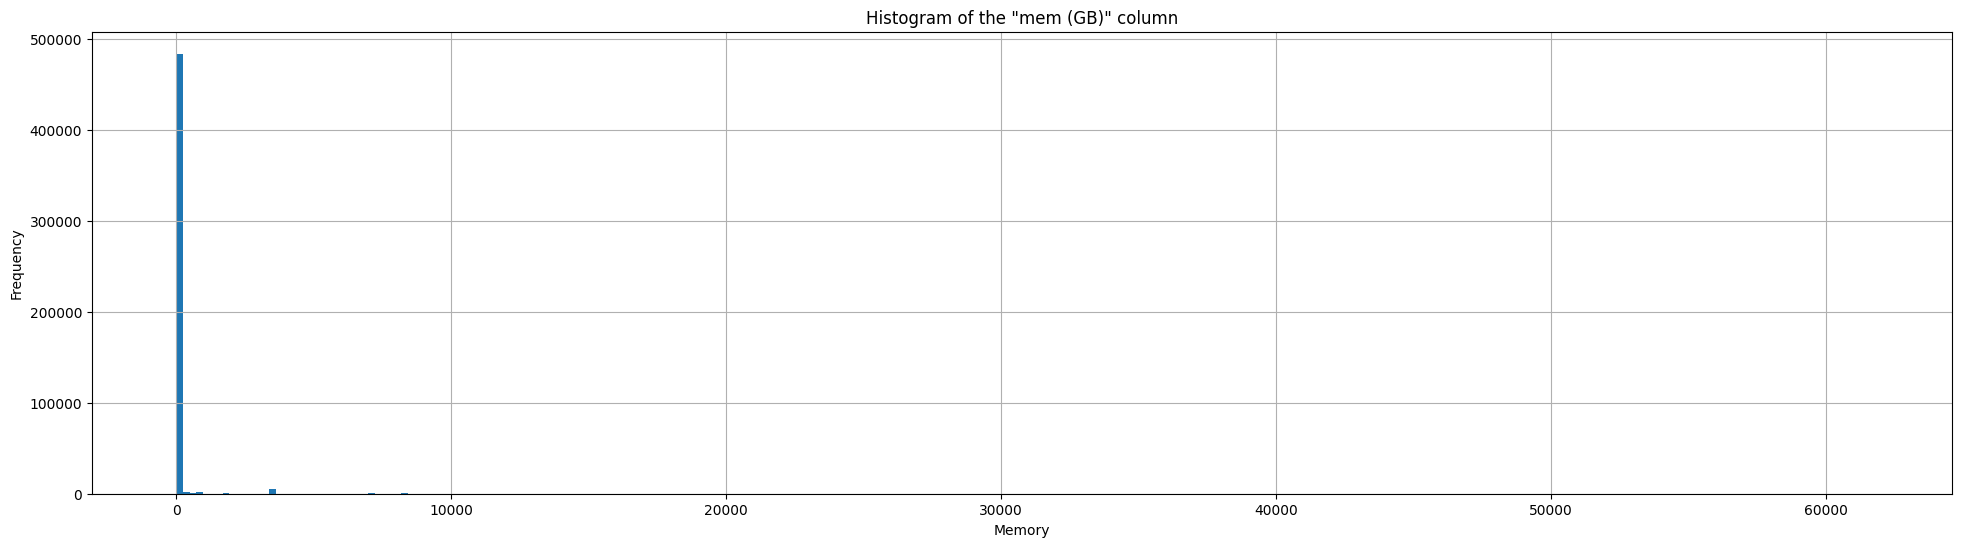

In [104]:
plt.figure(figsize=(24, 6))
plt.hist(df_best['mem (GB)'], bins=256)
plt.title('Histogram of the "mem (GB)" column')
plt.xlabel('Memory')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

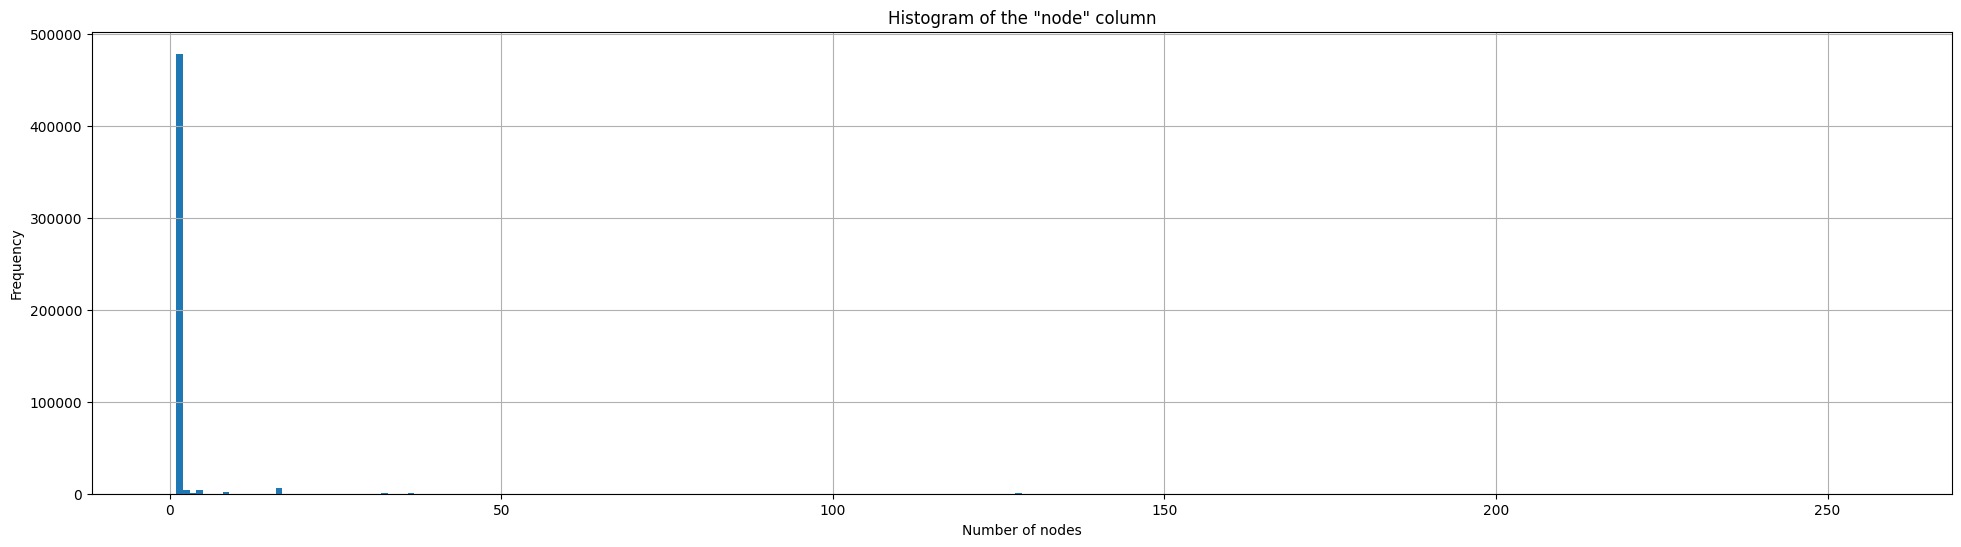

In [105]:
plt.figure(figsize=(24, 6))
plt.hist(df_best['node'], bins=256)
plt.title('Histogram of the "node" column')
plt.xlabel('Number of nodes')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

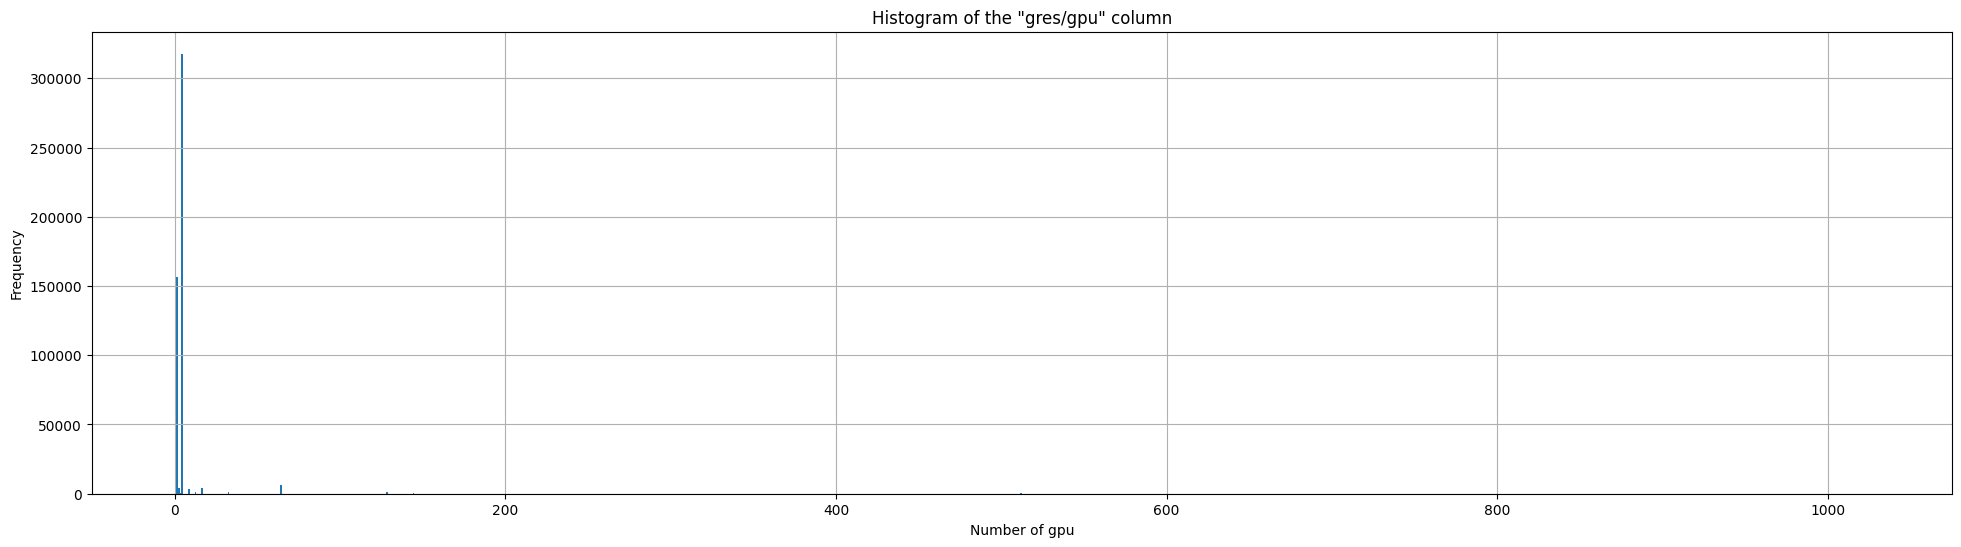

In [106]:
plt.figure(figsize=(24, 6))
plt.hist(df_best['gres/gpu'], bins=1024)
plt.title('Histogram of the "gres/gpu" column')
plt.xlabel('Number of gpu')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

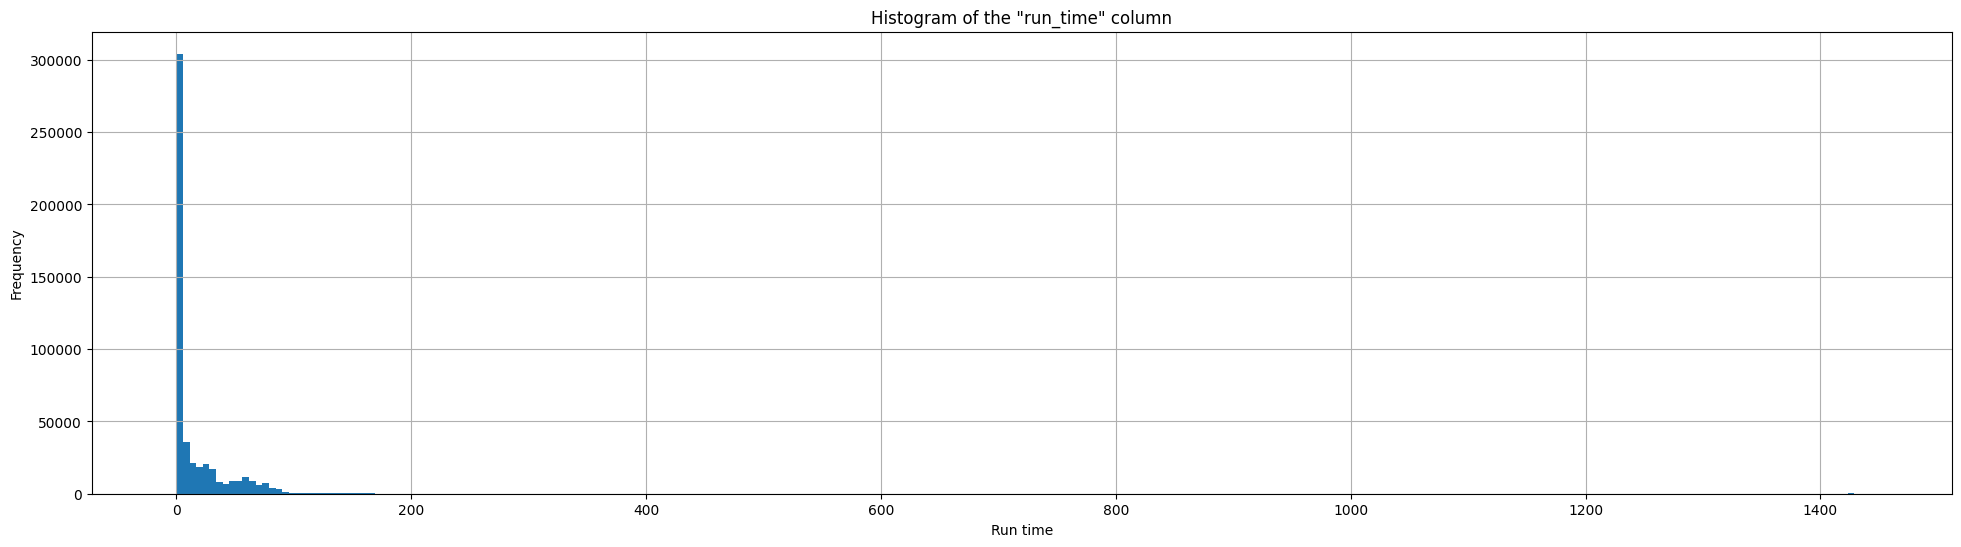

In [107]:
plt.figure(figsize=(24, 6))
plt.hist(df_best['run_time'], bins=256)
plt.title('Histogram of the "run_time" column')
plt.xlabel('Run time')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

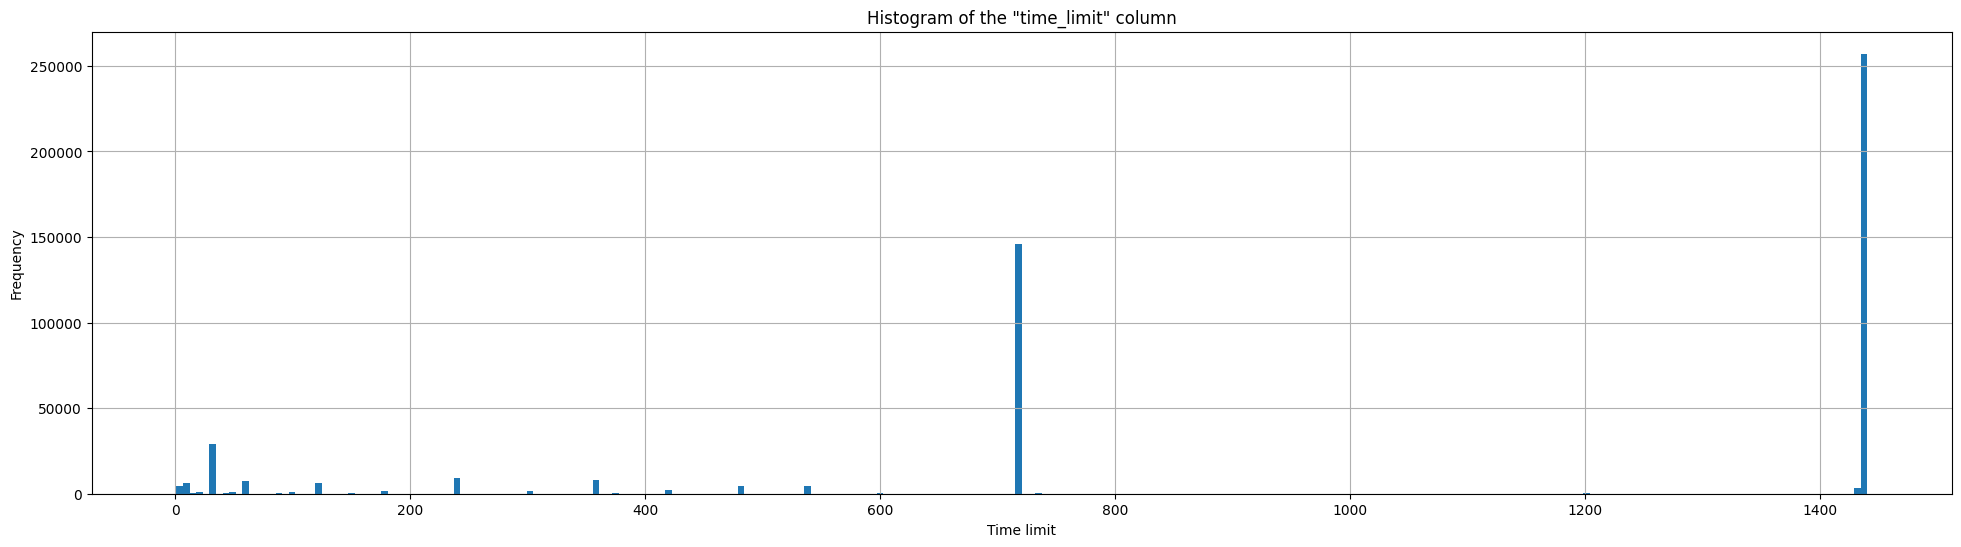

In [108]:
plt.figure(figsize=(24, 6))
plt.hist(df_best['time_limit'], bins=256)
plt.title('Histogram of the "time_limit" column')
plt.xlabel('Time limit')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

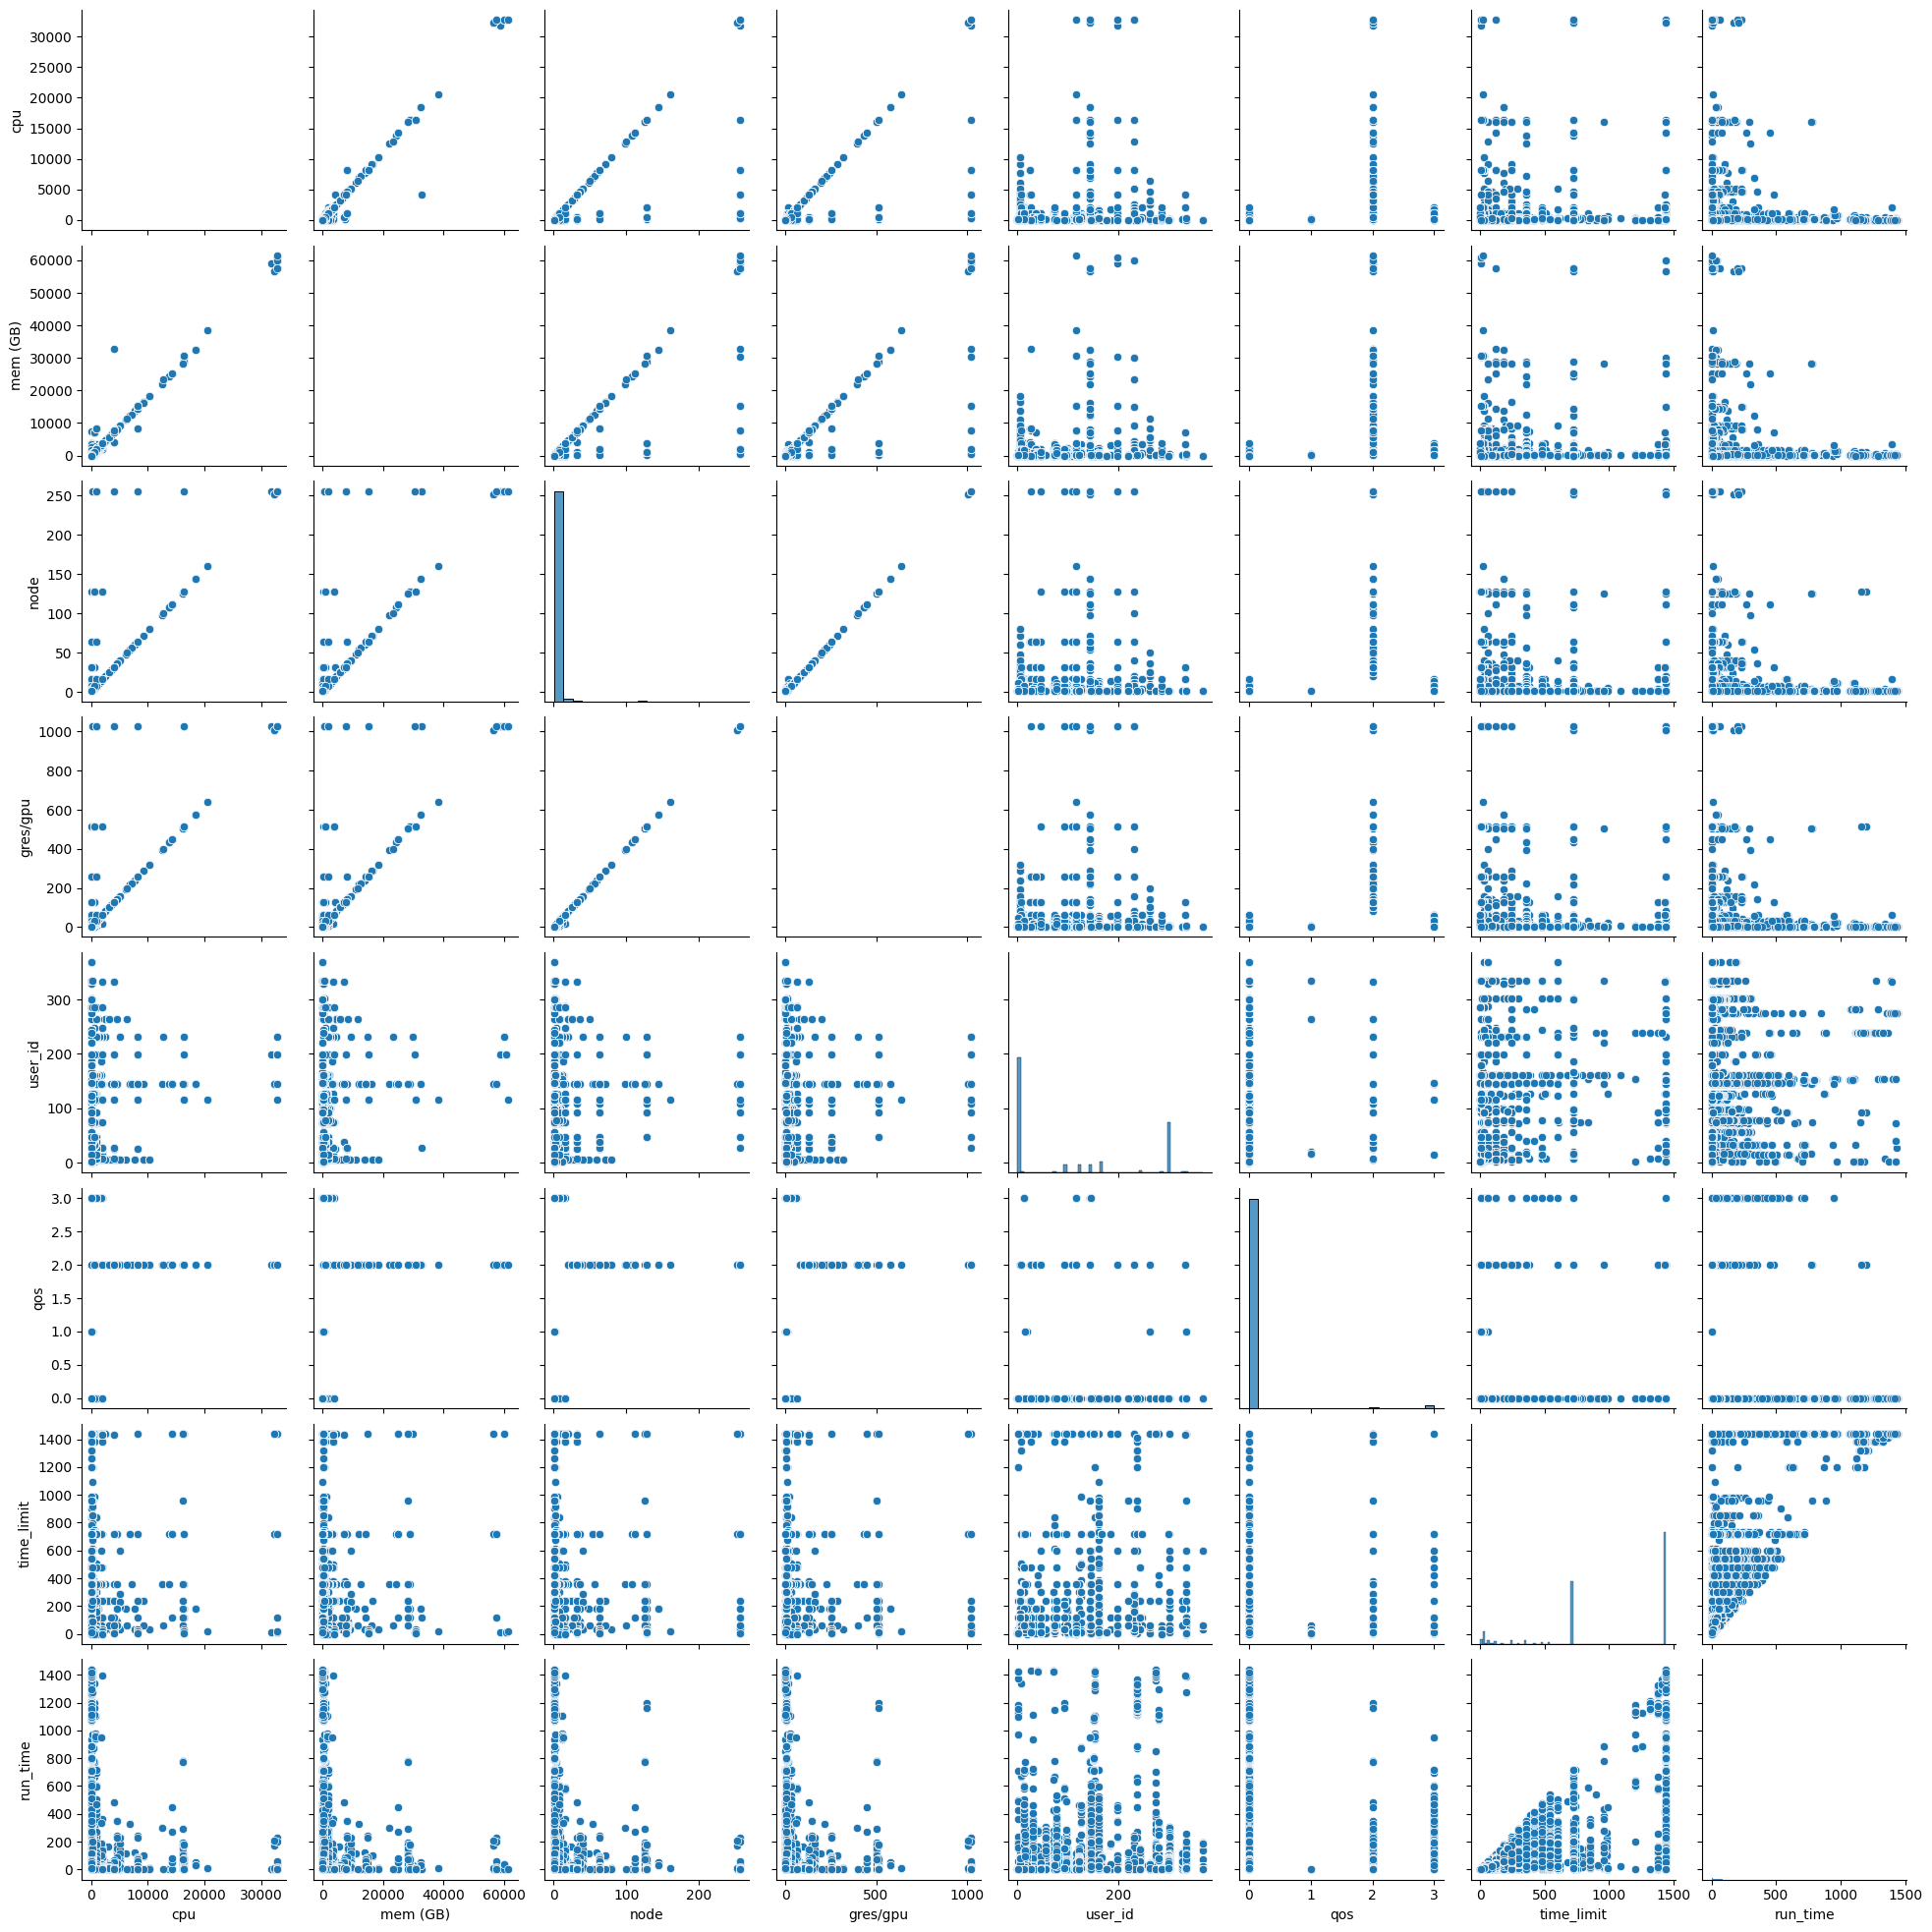

In [109]:
sns.pairplot(df_best)
plt.show()

In [110]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
# EXPERIMENT 3: We try to enhance the data by adding the average resources requested from each user to see if this helps the regression.
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [111]:
# Reset df
df = reset_df(df1)
df.shape

(628977, 8)

In [112]:
# Like in the last experiment, we consider only the user with experience (the one who submitted more than 10% of the average number of jobs submitted per user)
user_counts = df['user_id'].value_counts()
threshold = user_counts.mean()*0.1
df_f = df[df['user_id'].isin(user_counts[user_counts >= threshold].index)]
df_f.shape

(618548, 8)

In [113]:
# Group by "user_id" and calculate the mean for specified columns
df_a = df_f.groupby('user_id')[['cpu', 'mem (GB)', 'node', 'gres/gpu', 'time_limit', 'run_time']].mean().reset_index()

In [114]:
# Merge the filtered dataframe (df_f) with the averaged dataframe (df_a)
df_m = pd.merge(df_f, df_a, on='user_id', suffixes=('','_ApU'))

In [115]:
df_m.head()

cpu    mem (GB)  node  gres/gpu  user_id  qos  time_limit  run_time  \
0    1    1.855469     1         4        0    0        10.0  0.083333   
1    1    1.855469     1         4        0    0        10.0  0.100000   
2    4    9.765625     1         1        1    0        60.0  0.100000   
3  128  237.500000     1         4        2    0      1440.0  0.066667   
4    1    1.855469     1         4        0    0        10.0  0.100000   

      cpu_ApU  mem (GB)_ApU  node_ApU  gres/gpu_ApU  time_limit_ApU  \
0   14.732191     27.912636  1.001071      4.001071        9.947777   
1   14.732191     27.912636  1.001071      4.001071        9.947777   
2  329.076655    566.508330  3.042683     10.519164      453.501742   
3  126.986277    235.619069  1.026154      4.104616     1426.657636   
4   14.732191     27.912636  1.001071      4.001071        9.947777   

   run_time_ApU  
0      0.171795  
1      0.171795  
2    254.354123  
3      0.627018  
4      0.171795

In [116]:
X = df_m.drop(columns=['run_time'])
y = df_m['run_time']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=13)

true_values_3 = np.array(y_test)
initial_guesses_3 = np.array(X_test['time_limit'])

In [117]:
# Model 1: Decision Tree
y_pred_dt, dt_prev, dt_metrics = run_decision_tree(X_train, y_train)

Mean Absolute Error (Decision Tree): 22.25
Mean Squared Error (Decision Tree): 7324.18
Root Mean Squared Error (Decision Tree): 85.58
R² score (Decision Tree): 0.71


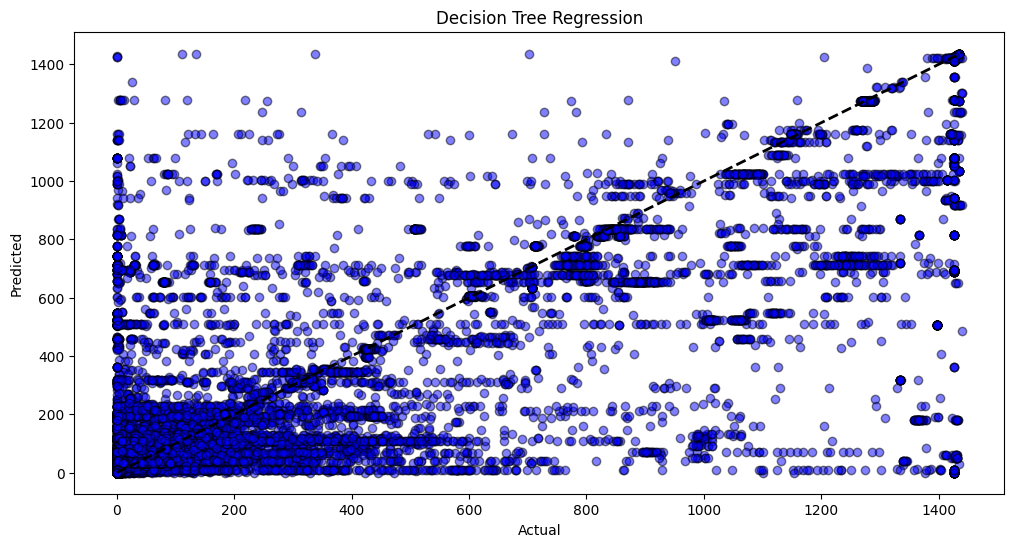

In [118]:
plot_regression(y_test, y_pred_dt, 'blue', 'Decision Tree Regression')

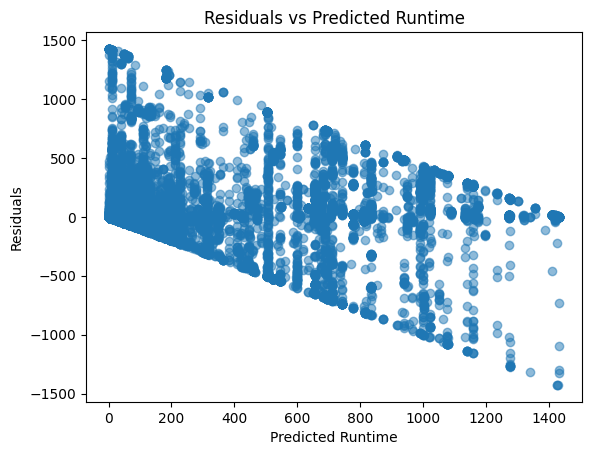

In [119]:
plot_residuals(y_test, y_pred_dt)

In [120]:
# Model 2: Random Forest
y_pred_rf, rf_prev, rf_metrics = run_random_forest(X_train, y_train)

Mean Absolute Error (Random Forest): 22.26
Mean Squared Error (Random Forest): 7277.36
Root Mean Squared Error (Random Forest): 85.31
R² score (Random Forest): 0.72


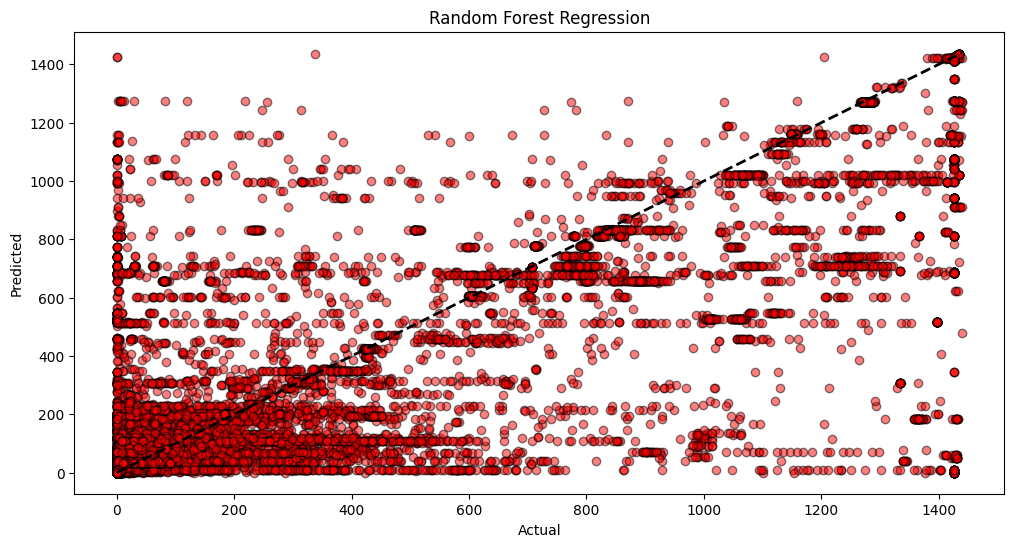

In [121]:
plot_regression(y_test, y_pred_rf, 'red', 'Random Forest Regression')

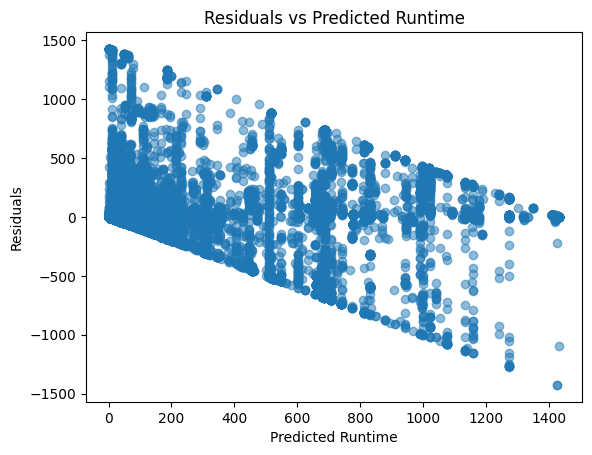

In [122]:
plot_residuals(y_test, y_pred_rf)

In [123]:
# Model 3: Gradient Boosting
y_pred_gb, gb_prev, gb_metrics = run_gradient_boosting(X_train, y_train)

Mean Absolute Error (Gradient Boosting): 25.89
Mean Squared Error (Gradient Boosting): 8448.96
Root Mean Squared Error (Gradient Boosting): 91.92
R² score (Gradient Boosting): 0.67


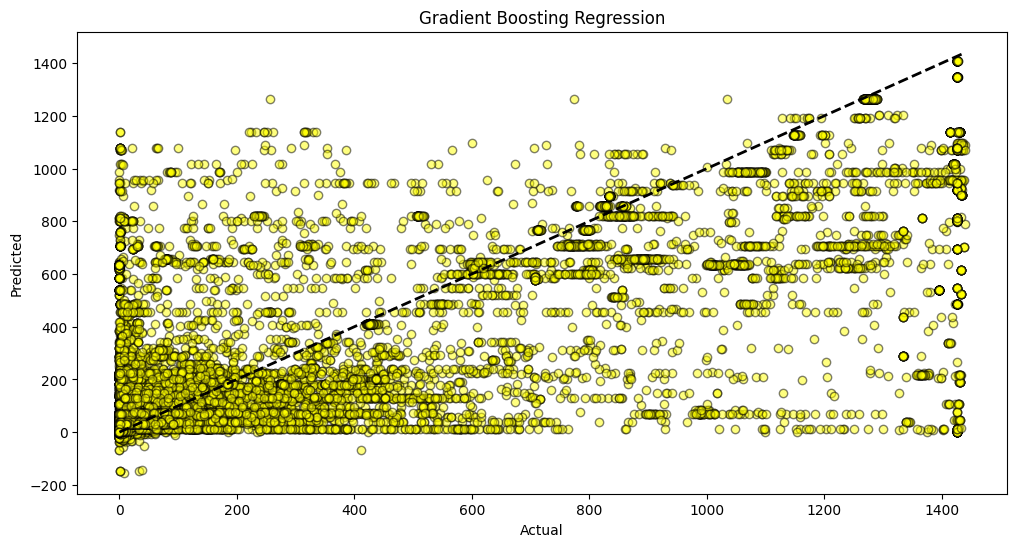

In [124]:
plot_regression(y_test, y_pred_gb, 'yellow', 'Gradient Boosting Regression')

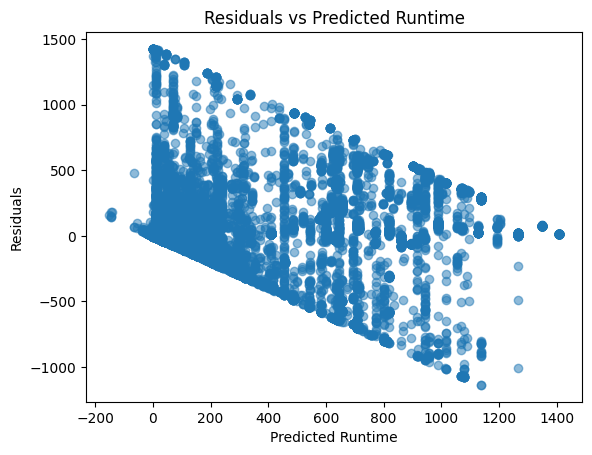

In [125]:
plot_residuals(y_test, y_pred_gb)

In [126]:
# Results Analysis

In [127]:
metrics_3 = [dt_metrics, rf_metrics, gb_metrics]
print(tabulate(metrics_3, headers=['MODEL', 'MAE', 'MSE', 'RMSE', 'R²'], tablefmt="heavy_grid", stralign="center", numalign="center"))

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┓
┃       MODEL       ┃  MAE  ┃   MSE   ┃  RMSE  ┃  R²  ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━╋━━━━━━━━━╋━━━━━━━━╋━━━━━━┫
┃   Decision Tree   ┃ 22.25 ┃ 7324.18 ┃ 85.58  ┃ 0.71 ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━╋━━━━━━━━━╋━━━━━━━━╋━━━━━━┫
┃   Random Forest   ┃ 22.26 ┃ 7277.36 ┃ 85.31  ┃ 0.72 ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━╋━━━━━━━━━╋━━━━━━━━╋━━━━━━┫
┃ Gradient Boosting ┃ 25.89 ┃ 8448.96 ┃ 91.92  ┃ 0.67 ┃
┗━━━━━━━━━━━━━━━━━━━┻━━━━━━━┻━━━━━━━━━┻━━━━━━━━┻━━━━━━┛


In [130]:
previsions_3 = (dt_prev, rf_prev, gb_prev)
evaluate_models(previsions_3, true_values_3)

The model "Decision Tree":
   - Overestimates the runtime in 79.91% of the cases (148281 out of 185565)
       • min(error)=0.01 ; max(error)=1426.80 ; avg(error)=13.99
       • The error is less than one hour in 96.20% of the cases (142646 out of 148281)
   - Underestimates the runtime in 19.69% of the cases (36530 out of 185565)
       • min(error)=0.01 ; max(error)=1425.42 ; avg(error)=56.24
       • The error is less than one hour in 87.46% of the cases (31950 out of 36530)
   - Exactly predict the runtime in the 0.41% of the cases (754 out of 185565)

The model "Random Forest":
   - Overestimates the runtime in 79.98% of the cases (148416 out of 185565)
       • min(error)=0.01 ; max(error)=1425.66 ; avg(error)=13.97
       • The error is less than one hour in 96.15% of the cases (142702 out of 148416)
   - Underestimates the runtime in 19.63% of the cases (36430 out of 185565)
       • min(error)=0.01 ; max(error)=1425.41 ; avg(error)=56.49
       • The error is less than one hou

In [131]:
compare_previsions(previsions_3, initial_guesses_3, true_values_3)

The model "Decision Tree":
   - In general, is more effective at approximating the actual "run_time" with respect to "time_limit" by 78.54%
   - In particular, for valid predictions (when it does not underestimate the actual "run_time"), it is more effective by 98.08%

The model "Random Forest":
   - In general, is more effective at approximating the actual "run_time" with respect to "time_limit" by 78.61%
   - In particular, for valid predictions (when it does not underestimate the actual "run_time"), it is more effective by 98.08%

The model "Gradient Boosting":
   - In general, is more effective at approximating the actual "run_time" with respect to "time_limit" by 76.67%
   - In particular, for valid predictions (when it does not underestimate the actual "run_time"), it is more effective by 96.98%



In [132]:
get_confidence_intervals(previsions_3)

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       MODEL       ┃  CONFIDENCE INTERVAL (95%)  ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃   Decision Tree   ┃       [0.00, 307.94]        ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃   Random Forest   ┃       [0.00, 306.92]        ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃ Gradient Boosting ┃       [0.00, 292.49]        ┃
┗━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [133]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
# EXPERIMENT 4: Instead of using a random split to obtain train and test sets we used a consecutive split over time
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [134]:
# For this experiment, also "start_time" is a relevant feature
r_f = df0[['user_id', 'qos', 'time_limit', 'start_time']]

df2 = tres_req_df.join(r_f)
df2 = df2.join(run_time)

df2 = df2.dropna().reset_index(drop=True)

df2 = df2[df2['run_time']!='0']

# Reset df
df_date = reset_df(df2)
df_date.shape

(628977, 9)

In [135]:
# Split the DataFrame based on the given date, in such a way that there are 30% of the jobs in df_after (30% = 185565 jobs)
split_date = '2020-10-4 04:37:55'

df_before = df_date[df_date['start_time'] < split_date]
df_after = df_date[df_date['start_time'] >= split_date]
print('Objective = 185565\nTest_jobs = {}'.format(df_after.shape[0]))

Objective = 185565
Test_jobs = 185565


In [136]:
df_before = df_before.drop(columns=['start_time'])
df_after = df_after.drop(columns=['start_time'])

In [137]:
df_before.describe()

cpu       mem (GB)           node       gres/gpu  \
count  443412.000000  443412.000000  443412.000000  443412.000000   
mean      117.155817     232.923331       1.851323       5.863457   
std       641.955717    1185.417869       7.726109      31.024940   
min         1.000000       0.097656       1.000000       1.000000   
25%         4.000000       7.812500       1.000000       1.000000   
50%        16.000000      29.687500       1.000000       3.000000   
75%       128.000000     237.500000       1.000000       4.000000   
max     32768.000000   61500.000000     256.000000    1024.000000   

             user_id            qos     time_limit       run_time  
count  443412.000000  443412.000000  443412.000000  443412.000000  
mean      146.255485       0.052479     911.370455      56.419118  
std       114.859188       0.366681     518.948737     189.746137  
min         0.000000       0.000000       1.000000       0.016667  
25%        22.000000       0.000000     720.000000       0.033333  
50%       123.000000       0.000000     720.000000       6.450000  
75%       300.000000       0.000000    1440.000000      32.266667  
max       375.000000       3.000000    1440.000000    1439.916667

In [138]:
df_after.describe()

cpu       mem (GB)           node       gres/gpu  \
count  185565.000000  185565.000000  185565.000000  185565.000000   
mean      131.471409     243.582654       1.315399       5.071430   
std       167.391545     300.265118       4.623796      18.521669   
min         1.000000       1.000000       1.000000       1.000000   
25%       128.000000     237.500000       1.000000       4.000000   
50%       128.000000     237.500000       1.000000       4.000000   
75%       128.000000     237.500000       1.000000       4.000000   
max      8192.000000   15375.000000     128.000000     512.000000   

             user_id            qos     time_limit       run_time  
count  185565.000000  185565.000000  185565.000000  185565.000000  
mean       26.399456       0.047886    1340.817422      12.401517  
std        77.593455       0.370428     308.870549      95.336283  
min         1.000000       0.000000       1.000000       0.016667  
25%         2.000000       0.000000    1440.000000       0.016667  
50%         2.000000       0.000000    1440.000000       0.016667  
75%         2.000000       0.000000    1440.000000       0.033333  
max       387.000000       3.000000    1440.000000    1439.600000

In [139]:
X_train = df_before.drop(columns=['run_time'])
X_test = df_after.drop(columns=['run_time'])
y_train = df_before['run_time']
y_test = df_after['run_time']

true_values_4 = np.array(y_test)
initial_guesses_4 = np.array(X_test['time_limit'])

In [140]:
# Model 1: Decision Tree
y_pred_dt, dt_prev, dt_metrics = run_decision_tree(X_train, y_train)

Mean Absolute Error (Decision Tree): 8.42
Mean Squared Error (Decision Tree): 3499.98
Root Mean Squared Error (Decision Tree): 59.16
R² score (Decision Tree): 0.61


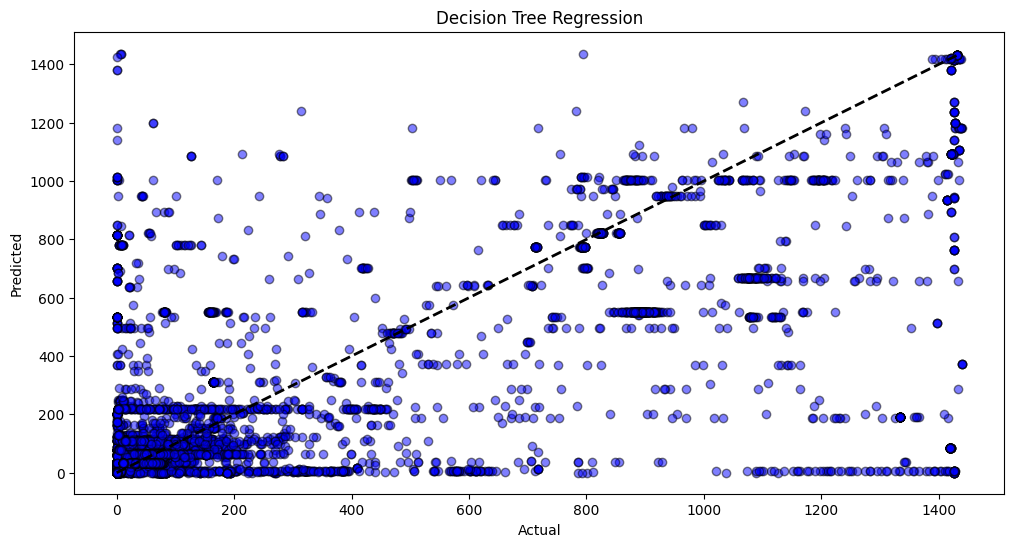

In [141]:
plot_regression(y_test, y_pred_dt, 'blue', 'Decision Tree Regression')

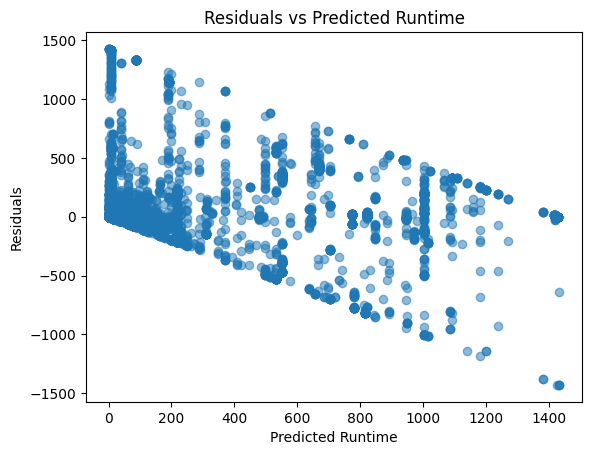

In [142]:
plot_residuals(y_test, y_pred_dt)

In [143]:
# Model 2: Random Forest
y_pred_rf, rf_prev, rf_metrics = run_random_forest(X_train, y_train)

Mean Absolute Error (Random Forest): 8.38
Mean Squared Error (Random Forest): 3428.09
Root Mean Squared Error (Random Forest): 58.55
R² score (Random Forest): 0.62


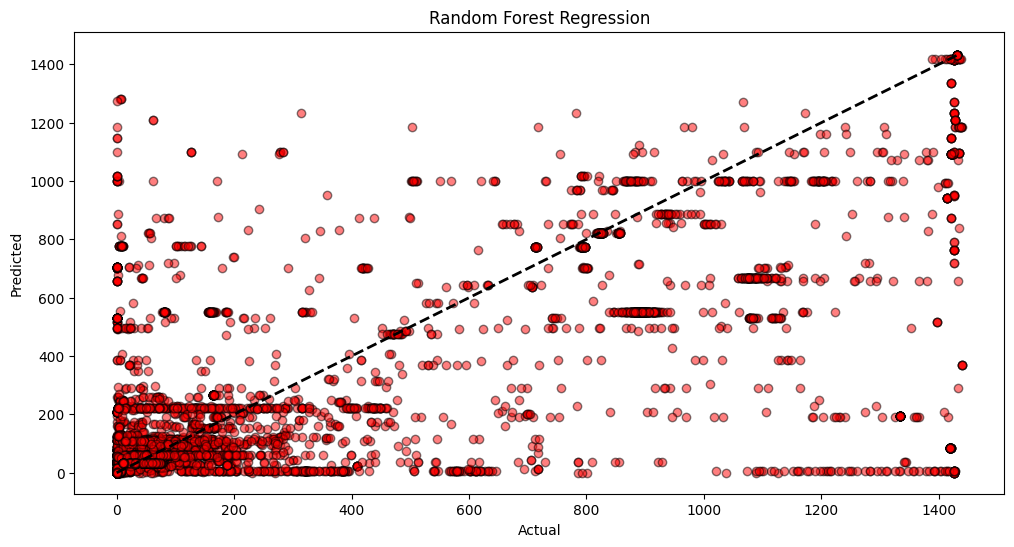

In [144]:
plot_regression(y_test, y_pred_rf, 'red', 'Random Forest Regression')

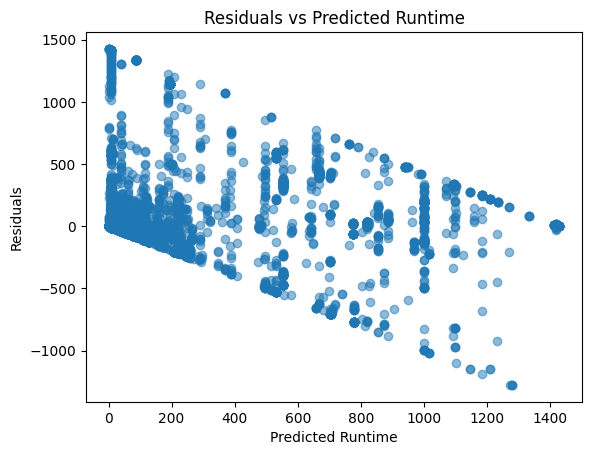

In [145]:
plot_residuals(y_test, y_pred_rf)

In [146]:
# Model 3: Gradient Boosting
y_pred_gb, gb_prev, gb_metrics = run_gradient_boosting(X_train, y_train)

Mean Absolute Error (Gradient Boosting): 13.45
Mean Squared Error (Gradient Boosting): 4134.00
Root Mean Squared Error (Gradient Boosting): 64.30
R² score (Gradient Boosting): 0.55


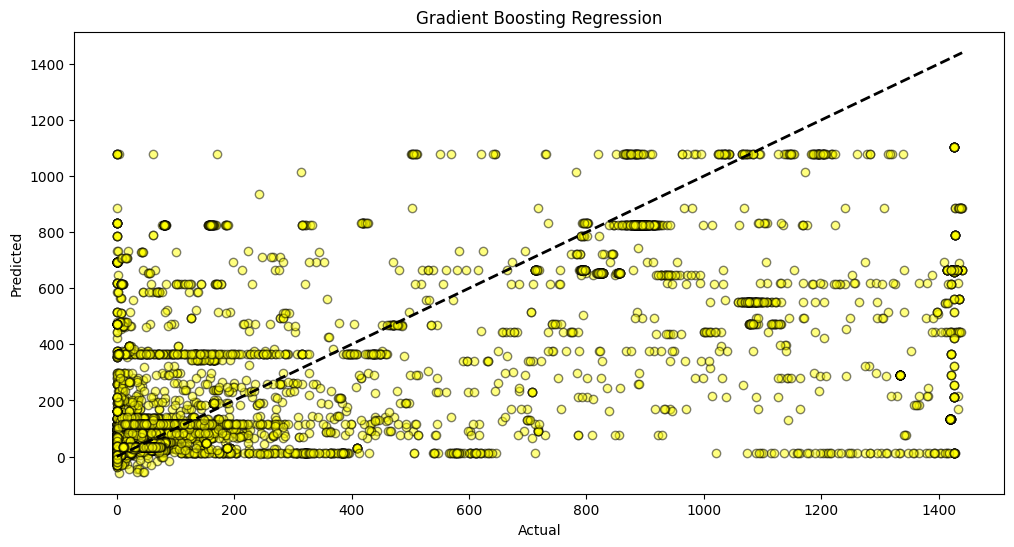

In [147]:
plot_regression(y_test, y_pred_gb, 'yellow', 'Gradient Boosting Regression')

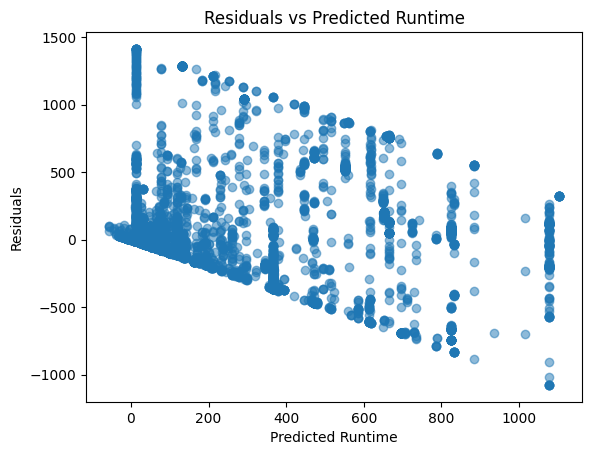

In [148]:
plot_residuals(y_test, y_pred_gb)

In [149]:
metrics_4 = [dt_metrics, rf_metrics, gb_metrics]
print(tabulate(metrics_4, headers=['MODEL', 'MAE', 'MSE', 'RMSE', 'R²'], tablefmt="heavy_grid", stralign="center", numalign="center"))

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━┳━━━━━━━━┳━━━━━━┓
┃       MODEL       ┃  MAE  ┃   MSE   ┃  RMSE  ┃  R²  ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━╋━━━━━━━━━╋━━━━━━━━╋━━━━━━┫
┃   Decision Tree   ┃ 8.42  ┃ 3499.98 ┃ 59.16  ┃ 0.61 ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━╋━━━━━━━━━╋━━━━━━━━╋━━━━━━┫
┃   Random Forest   ┃ 8.38  ┃ 3428.09 ┃ 58.55  ┃ 0.62 ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━╋━━━━━━━━━╋━━━━━━━━╋━━━━━━┫
┃ Gradient Boosting ┃ 13.45 ┃  4134   ┃  64.3  ┃ 0.55 ┃
┗━━━━━━━━━━━━━━━━━━━┻━━━━━━━┻━━━━━━━━━┻━━━━━━━━┻━━━━━━┛


In [150]:
previsions_4 = (dt_prev, rf_prev, gb_prev)
evaluate_models(previsions_4, true_values_4)

The model "Decision Tree":
   - Overestimates the runtime in 94.81% of the cases (175934 out of 185565)
       • min(error)=0.01 ; max(error)=1428.98 ; avg(error)=4.26
       • The error is less than one hour in 99.12% of the cases (174386 out of 175934)
   - Underestimates the runtime in 5.18% of the cases (9614 out of 185565)
       • min(error)=0.01 ; max(error)=1425.71 ; avg(error)=84.47
       • The error is less than one hour in 80.94% of the cases (7782 out of 9614)
   - Exactly predict the runtime in the 0.01% of the cases (17 out of 185565)

The model "Random Forest":
   - Overestimates the runtime in 94.88% of the cases (176055 out of 185565)
       • min(error)=0.01 ; max(error)=1275.88 ; avg(error)=4.23
       • The error is less than one hour in 99.12% of the cases (174499 out of 176055)
   - Underestimates the runtime in 5.12% of the cases (9495 out of 185565)
       • min(error)=0.01 ; max(error)=1425.71 ; avg(error)=85.22
       • The error is less than one hour in 81.0

In [151]:
compare_previsions(previsions_4, initial_guesses_4, true_values_4)

The model "Decision Tree":
   - In general, is more effective at approximating the actual "run_time" with respect to "time_limit" by 94.15%
   - In particular, for valid predictions (when it does not underestimate the actual "run_time"), it is more effective by 99.31%

The model "Random Forest":
   - In general, is more effective at approximating the actual "run_time" with respect to "time_limit" by 94.23%
   - In particular, for valid predictions (when it does not underestimate the actual "run_time"), it is more effective by 99.32%

The model "Gradient Boosting":
   - In general, is more effective at approximating the actual "run_time" with respect to "time_limit" by 92.81%
   - In particular, for valid predictions (when it does not underestimate the actual "run_time"), it is more effective by 99.01%



In [152]:
get_confidence_intervals(previsions_4)

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       MODEL       ┃  CONFIDENCE INTERVAL (95%)  ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃   Decision Tree   ┃       [0.00, 157.58]        ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃   Random Forest   ┃       [0.00, 155.83]        ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃ Gradient Boosting ┃       [0.00, 151.81]        ┃
┗━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛


In [153]:
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------
# EXPERIMENT 5: We add 60 minutes to each prevision to see how this change our results, in particular how this impact:
# 1) The percentage of cases in which the models underestimates the runtime (should decrease from 20% to 3%)
# 2) The effectiveness with respect to "time_limit" in predicting the actual runtime
# 3) The confidence intervals
# ----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [155]:
safe_previsions_1 = ((previsions_1[0][0], previsions_1[0][1]+60), (previsions_1[1][0], previsions_1[1][1]+60),(previsions_1[2][0], previsions_1[2][1]+60))
safe_previsions_2 = ((previsions_2[0][0], previsions_2[0][1]+60), (previsions_2[1][0], previsions_2[1][1]+60),(previsions_2[2][0], previsions_2[2][1]+60))
safe_previsions_3 = ((previsions_3[0][0], previsions_3[0][1]+60), (previsions_3[1][0], previsions_3[1][1]+60),(previsions_3[2][0], previsions_3[2][1]+60))
safe_previsions_4 = ((previsions_4[0][0], previsions_4[0][1]+60), (previsions_4[1][0], previsions_4[1][1]+60),(previsions_4[2][0], previsions_4[2][1]+60))

In [156]:
print('_____________________________________________________________________________________\n')
print('                                    EXPERIMENT 1                                     ')
print('_____________________________________________________________________________________\n')
evaluate_models(safe_previsions_1, true_values_1)
print('_____________________________________________________________________________________\n')
print('                                    EXPERIMENT 2                                     ')
print('_____________________________________________________________________________________\n')
evaluate_models(safe_previsions_2, true_values_2)
print('_____________________________________________________________________________________\n')
print('                                    EXPERIMENT 3                                     ')
print('_____________________________________________________________________________________\n')
evaluate_models(safe_previsions_3, true_values_3)
print('_____________________________________________________________________________________\n')
print('                                    EXPERIMENT 4                                     ')
print('_____________________________________________________________________________________\n')
evaluate_models(safe_previsions_4, true_values_4)

_____________________________________________________________________________________

                                    EXPERIMENT 1                                     
_____________________________________________________________________________________

The model "Decision Tree":
   - Overestimates the runtime in 97.09% of the cases (183201 out of 188694)
       • min(error)=0.01 ; max(error)=1491.00 ; avg(error)=69.20
       • The error is less than one hour in 17.81% of the cases (32632 out of 183201)
   - Underestimates the runtime in 2.91% of the cases (5492 out of 188694)
       • min(error)=0.02 ; max(error)=1365.53 ; avg(error)=246.84
       • The error is less than one hour in 29.73% of the cases (1633 out of 5492)
   - Exactly predict the runtime in the 0.00% of the cases (1 out of 188694)

The model "Random Forest":
   - Overestimates the runtime in 97.08% of the cases (183179 out of 188694)
       • min(error)=0.02 ; max(error)=1411.29 ; avg(error)=69.19
       • The e

In [157]:
print('________________________________________________________________________________________________________________________________\n')
print('                                                         EXPERIMENT 1')
print('________________________________________________________________________________________________________________________________\n')
compare_previsions(safe_previsions_1, initial_guesses_1, true_values_1)
print('________________________________________________________________________________________________________________________________\n')
print('                                                         EXPERIMENT 2')
print('________________________________________________________________________________________________________________________________\n')
compare_previsions(safe_previsions_2, initial_guesses_2, true_values_2)
print('________________________________________________________________________________________________________________________________\n')
print('                                                         EXPERIMENT 3')
print('________________________________________________________________________________________________________________________________\n')
compare_previsions(safe_previsions_3, initial_guesses_3, true_values_3)
print('________________________________________________________________________________________________________________________________\n')
print('                                                         EXPERIMENT 4')
print('________________________________________________________________________________________________________________________________\n')
compare_previsions(safe_previsions_4, initial_guesses_4, true_values_4)

________________________________________________________________________________________________________________________________

                                                         EXPERIMENT 1
________________________________________________________________________________________________________________________________

The model "Decision Tree":
   - In general, is more effective at approximating the actual "run_time" with respect to "time_limit" by 79.39%
   - In particular, for valid predictions (when it does not underestimate the actual "run_time"), it is more effective by 91.39%

The model "Random Forest":
   - In general, is more effective at approximating the actual "run_time" with respect to "time_limit" by 79.39%
   - In particular, for valid predictions (when it does not underestimate the actual "run_time"), it is more effective by 91.37%

The model "Gradient Boosting":
   - In general, is more effective at approximating the actual "run_time" with respect to "time_lim

In [158]:
print('___________________________________________________\n')
print('                  EXPERIMENT 1')
print('___________________________________________________\n')
get_confidence_intervals(safe_previsions_1)
print('___________________________________________________\n')
print('                  EXPERIMENT 2')
print('___________________________________________________\n')
get_confidence_intervals(safe_previsions_2)
print('___________________________________________________\n')
print('                  EXPERIMENT 3')
print('___________________________________________________\n')
get_confidence_intervals(safe_previsions_3)
print('___________________________________________________\n')
print('                  EXPERIMENT 4')
print('___________________________________________________\n')
get_confidence_intervals(safe_previsions_4)

___________________________________________________

                  EXPERIMENT 1
___________________________________________________

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       MODEL       ┃  CONFIDENCE INTERVAL (95%)  ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃   Decision Tree   ┃       [0.00, 386.96]        ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃   Random Forest   ┃       [0.00, 385.80]        ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃ Gradient Boosting ┃       [0.00, 319.85]        ┃
┗━━━━━━━━━━━━━━━━━━━┻━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛
___________________________________________________

                  EXPERIMENT 2
___________________________________________________

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃       MODEL       ┃  CONFIDENCE INTERVAL (95%)  ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┫
┃   Decision Tree   ┃       [0.00, 187.69]        ┃
┣━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━